# Benchmarks

## Initialize

In [1]:
%load_ext autoreload
%autoreload 2

import os
from tqdm.auto import tqdm
import pathlib

import numpy as np
import pandas as pd
import lifelines
import pandas as pd

from joblib import Parallel, delayed
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")
import shutil

import plotly.express as px
import plotly.graph_objects as go
from plotly.graph_objects import Box

import matplotlib.pyplot as plt
from lifelines import CRCSplineFitter
import warnings
from lifelines.utils import CensoringType

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import math

from IPython.display import clear_output
import pathlib

from lifelines.utils import concordance_index

In [2]:
node = !hostname
if "sc" in node[0]:
    base_path = "/sc-projects/sc-proj-ukb-cvd"
else: base_path = "/data/analysis/ag-reils/ag-reils-shared/cardioRS"
print(base_path)

project_name = "210714_metabolomics"
#data_path = "/data/analysis/ag-reils/steinfej"
data_pre = f"{base_path}/data/2_datasets_pre/{project_name}"
data_post = f"{base_path}/data/3_datasets_post/{project_name}"

project_label = "21_metabolomics_multitask"
project_path = f"{base_path}/results/projects/{project_label}"
figures_path = f"{project_path}/figures"
data_results_path = f"{project_path}/data"
pathlib.Path(figures_path).mkdir(parents=True, exist_ok=True)
pathlib.Path(data_results_path).mkdir(parents=True, exist_ok=True)

/sc-projects/sc-proj-ukb-cvd


In [3]:
endpoints = [
    # Psychiatric/Neurological
    'M_all_cause_dementia'
]

In [4]:
partitions = [str(p) for p in range(0, 22)]
splits = ["train", "valid", "test"]

In [5]:
run = "220126_apoe4"

In [6]:
!ls {data_results_path}

MET_HRs_210819_metabolomics.feather
MET_HRs_210821_metabolomics.feather
NMR_acetone_IMPUTER.pkl
NMR_clinical_ldl_cholesterol_IMPUTER.pkl
REVISION_220110_attrib_raw.feather
REVISION_220111_temp_umap_shap.feather
add_data_211005.feather
adj_partial_effects_metabolomics_210914.feather
adj_partial_effects_metabolomics_210916.feather
adj_partial_effects_metabolomics_210920.feather
adj_partial_effects_metabolomics_210922A.feather
adj_partial_effects_metabolomics_211005_incl_cancer.feather
adj_partial_effects_metabolomics_211006_improved.feather
adj_partial_effects_metabolomics_211007.feather
attrib_raw_REVISION.feather
attrib_sample_wide_211028.feather
attributions_210915.feather
attributions_210916.feather
attributions_210917.feather
attributions_210924.feather
attributions_211008.feather
attributions_211014_Kernelexplainer.feather
attributions_211026.feather
benchmark1000_cindex_subgroups_220106.feather
benchmark100_cindex_subgroups_220103.feather
benchmark_cindex1000_centres_211007_220120

In [7]:
data_temp = pd.read_feather(f"{data_post}/data_merged.feather")
eids_dict = {}
for endpoint in tqdm(endpoints):
    eids_incl = data_temp.query(f"NMR_FLAG==True&{endpoint}==False").eid.to_list()
    if endpoint == "M_MACE": eids_incl = data_temp.copy().query(f"NMR_FLAG==True&{endpoint}==False&statins==False").eid.to_list()
    if endpoint == "M_breast_cancer": eids_incl = data_temp.copy().query(f"NMR_FLAG==True&{endpoint}==False&sex=='Female'").eid.to_list()
    if endpoint == "M_ovarian_cancer": eids_incl = data_temp.copy().query(f"NMR_FLAG==True&{endpoint}==False&sex=='Female'").eid.to_list()
    if endpoint == "M_uterus_cancer": eids_incl = data_temp.copy().query(f"NMR_FLAG==True&{endpoint}==False&sex=='Female'").eid.to_list()
    if endpoint == "M_prostate_cancer": eids_incl = data_temp.copy().query(f"NMR_FLAG==True&{endpoint}==False&sex=='Male'").eid.to_list()
    print(endpoint, len(eids_incl))
    eids_dict[endpoint] = eids_incl

  0%|          | 0/1 [00:00<?, ?it/s]

M_all_cause_dementia 117245


In [8]:
metabolomics = [
'NMR_3hydroxybutyrate',
 'NMR_acetate',
 'NMR_acetoacetate',
 'NMR_acetone',
 'NMR_alanine',
 'NMR_albumin',
 'NMR_apolipoprotein_a1',
 'NMR_apolipoprotein_b',
 'NMR_average_diameter_for_hdl_particles',
 'NMR_average_diameter_for_ldl_particles',
 'NMR_average_diameter_for_vldl_particles',
 'NMR_cholesterol_in_chylomicrons_and_extremely_large_vldl',
 'NMR_cholesterol_in_idl',
 'NMR_cholesterol_in_large_hdl',
 'NMR_cholesterol_in_large_ldl',
 'NMR_cholesterol_in_large_vldl',
 'NMR_cholesterol_in_medium_hdl',
 'NMR_cholesterol_in_medium_ldl',
 'NMR_cholesterol_in_medium_vldl',
 'NMR_cholesterol_in_small_hdl',
 'NMR_cholesterol_in_small_ldl',
 'NMR_cholesterol_in_small_vldl',
 'NMR_cholesterol_in_very_large_hdl',
 'NMR_cholesterol_in_very_large_vldl',
 'NMR_cholesterol_in_very_small_vldl',
 'NMR_cholesteryl_esters_in_chylomicrons_and_extremely_large_vldl',
 'NMR_cholesteryl_esters_in_hdl',
 'NMR_cholesteryl_esters_in_idl',
 'NMR_cholesteryl_esters_in_ldl',
 'NMR_cholesteryl_esters_in_large_hdl',
 'NMR_cholesteryl_esters_in_large_ldl',
 'NMR_cholesteryl_esters_in_large_vldl',
 'NMR_cholesteryl_esters_in_medium_hdl',
 'NMR_cholesteryl_esters_in_medium_ldl',
 'NMR_cholesteryl_esters_in_medium_vldl',
 'NMR_cholesteryl_esters_in_small_hdl',
 'NMR_cholesteryl_esters_in_small_ldl',
 'NMR_cholesteryl_esters_in_small_vldl',
 'NMR_cholesteryl_esters_in_vldl',
 'NMR_cholesteryl_esters_in_very_large_hdl',
 'NMR_cholesteryl_esters_in_very_large_vldl',
 'NMR_cholesteryl_esters_in_very_small_vldl',
 'NMR_citrate',
 'NMR_clinical_ldl_cholesterol',
 'NMR_concentration_of_chylomicrons_and_extremely_large_vldl_particles',
 'NMR_concentration_of_hdl_particles',
 'NMR_concentration_of_idl_particles',
 'NMR_concentration_of_ldl_particles',
 'NMR_concentration_of_large_hdl_particles',
 'NMR_concentration_of_large_ldl_particles',
 'NMR_concentration_of_large_vldl_particles',
 'NMR_concentration_of_medium_hdl_particles',
 'NMR_concentration_of_medium_ldl_particles',
 'NMR_concentration_of_medium_vldl_particles',
 'NMR_concentration_of_small_hdl_particles',
 'NMR_concentration_of_small_ldl_particles',
 'NMR_concentration_of_small_vldl_particles',
 'NMR_concentration_of_vldl_particles',
 'NMR_concentration_of_very_large_hdl_particles',
 'NMR_concentration_of_very_large_vldl_particles',
 'NMR_concentration_of_very_small_vldl_particles',
 'NMR_creatinine',
 'NMR_degree_of_unsaturation',
 'NMR_docosahexaenoic_acid',
 'NMR_free_cholesterol_in_chylomicrons_and_extremely_large_vldl',
 'NMR_free_cholesterol_in_hdl',
 'NMR_free_cholesterol_in_idl',
 'NMR_free_cholesterol_in_ldl',
 'NMR_free_cholesterol_in_large_hdl',
 'NMR_free_cholesterol_in_large_ldl',
 'NMR_free_cholesterol_in_large_vldl',
 'NMR_free_cholesterol_in_medium_hdl',
 'NMR_free_cholesterol_in_medium_ldl',
 'NMR_free_cholesterol_in_medium_vldl',
 'NMR_free_cholesterol_in_small_hdl',
 'NMR_free_cholesterol_in_small_ldl',
 'NMR_free_cholesterol_in_small_vldl',
 'NMR_free_cholesterol_in_vldl',
 'NMR_free_cholesterol_in_very_large_hdl',
 'NMR_free_cholesterol_in_very_large_vldl',
 'NMR_free_cholesterol_in_very_small_vldl',
 'NMR_glucose',
 'NMR_glutamine',
 'NMR_glycine',
 'NMR_glycoprotein_acetyls',
 'NMR_hdl_cholesterol',
 'NMR_histidine',
 'NMR_isoleucine',
 'NMR_ldl_cholesterol',
 'NMR_lactate',
 'NMR_leucine',
 'NMR_linoleic_acid',
 'NMR_monounsaturated_fatty_acids',
 'NMR_omega3_fatty_acids',
 'NMR_omega6_fatty_acids',
 'NMR_phenylalanine',
 'NMR_phosphatidylcholines',
 'NMR_phosphoglycerides',
 'NMR_phospholipids_in_chylomicrons_and_extremely_large_vldl',
 'NMR_phospholipids_in_hdl',
 'NMR_phospholipids_in_idl',
 'NMR_phospholipids_in_ldl',
 'NMR_phospholipids_in_large_hdl',
 'NMR_phospholipids_in_large_ldl',
 'NMR_phospholipids_in_large_vldl',
 'NMR_phospholipids_in_medium_hdl',
 'NMR_phospholipids_in_medium_ldl',
 'NMR_phospholipids_in_medium_vldl',
 'NMR_phospholipids_in_small_hdl',
 'NMR_phospholipids_in_small_ldl',
 'NMR_phospholipids_in_small_vldl',
 'NMR_phospholipids_in_vldl',
 'NMR_phospholipids_in_very_large_hdl',
 'NMR_phospholipids_in_very_large_vldl',
 'NMR_phospholipids_in_very_small_vldl',
 'NMR_polyunsaturated_fatty_acids',
 'NMR_pyruvate',
 'NMR_remnant_cholesterol_nonhdl_nonldl_cholesterol',
 'NMR_saturated_fatty_acids',
 'NMR_sphingomyelins',
 'NMR_total_cholesterol',
 'NMR_total_cholesterol_minus_hdlc',
 'NMR_total_cholines',
 'NMR_total_concentration_of_branchedchain_amino_acids_leucine_isoleucine_valine',
 'NMR_total_concentration_of_lipoprotein_particles',
 'NMR_total_esterified_cholesterol',
 'NMR_total_fatty_acids',
 'NMR_total_free_cholesterol',
 'NMR_total_lipids_in_chylomicrons_and_extremely_large_vldl',
 'NMR_total_lipids_in_hdl',
 'NMR_total_lipids_in_idl',
 'NMR_total_lipids_in_ldl',
 'NMR_total_lipids_in_large_hdl',
 'NMR_total_lipids_in_large_ldl',
 'NMR_total_lipids_in_large_vldl',
 'NMR_total_lipids_in_lipoprotein_particles',
 'NMR_total_lipids_in_medium_hdl',
 'NMR_total_lipids_in_medium_ldl',
 'NMR_total_lipids_in_medium_vldl',
 'NMR_total_lipids_in_small_hdl',
 'NMR_total_lipids_in_small_ldl',
 'NMR_total_lipids_in_small_vldl',
 'NMR_total_lipids_in_vldl',
 'NMR_total_lipids_in_very_large_hdl',
 'NMR_total_lipids_in_very_large_vldl',
 'NMR_total_lipids_in_very_small_vldl',
 'NMR_total_phospholipids_in_lipoprotein_particles',
 'NMR_total_triglycerides',
 'NMR_triglycerides_in_chylomicrons_and_extremely_large_vldl',
 'NMR_triglycerides_in_hdl',
 'NMR_triglycerides_in_idl',
 'NMR_triglycerides_in_ldl',
 'NMR_triglycerides_in_large_hdl',
 'NMR_triglycerides_in_large_ldl',
 'NMR_triglycerides_in_large_vldl',
 'NMR_triglycerides_in_medium_hdl',
 'NMR_triglycerides_in_medium_ldl',
 'NMR_triglycerides_in_medium_vldl',
 'NMR_triglycerides_in_small_hdl',
 'NMR_triglycerides_in_small_ldl',
 'NMR_triglycerides_in_small_vldl',
 'NMR_triglycerides_in_vldl',
 'NMR_triglycerides_in_very_large_hdl',
 'NMR_triglycerides_in_very_large_vldl',
 'NMR_triglycerides_in_very_small_vldl',
 'NMR_tyrosine',
 'NMR_vldl_cholesterol',
 'NMR_valine'
]

In [48]:
PANEL = [ # 38 clinical predictors
    # basics
    "age_at_recruitment", 
    "sex", 
    'smoking_status_2.0', # current smoker
    'alcohol_intake_frequency_2.0', # 'Daily or almost daily'
    "daily_physical_activity",
    "education_years",
    "daily_healthy_food",
    
    # family history
    "fh_diabetes",
    
    # diagnoses
    "diabetes2",
        
    # physical
    "body_mass_index_bmi", 
    'waist_hip_ratio',
    "waist_circumference",
    "weight", 
    "standing_height", 
    "systolic_blood_pressure", 
    
    # lipids
    "cholesterol", 
    "ldl_direct", 
    "hdl_cholesterol",
    "triglycerides",
    
    # diabetes
    'glucose',
    'glycated_haemoglobin_hba1c',
    
    # kidney
    'creatinine',
    'cystatin_c',
    'urea',
    'urate',
        
    # liver
    'aspartate_aminotransferase',
    'alanine_aminotransferase',
    'alkaline_phosphatase',
    'albumin',
    
    # inflammation
    'creactive_protein',
    
    # Blood counts
    'red_blood_cell_erythrocyte_count',
    'white_blood_cell_leukocyte_count',
    'platelet_count',
    'haemoglobin_concentration',
    'haematocrit_percentage',
    'mean_corpuscular_haemoglobin',
    'mean_corpuscular_volume',
    'mean_corpuscular_haemoglobin_concentration',
    
    # medications
    'antihypertensives'
        ] 

In [49]:
PANELapoe4 = [ # 38 clinical predictors
    # basics
    "age_at_recruitment", 
    "sex", 
    'smoking_status_2.0', # current smoker
    'alcohol_intake_frequency_2.0', # 'Daily or almost daily'
    "daily_physical_activity",
    "education_years",
    "daily_healthy_food",
    
    # family history
    "fh_diabetes",
    
    # diagnoses
    "diabetes2",
        
    # physical
    "body_mass_index_bmi", 
    'waist_hip_ratio',
    "waist_circumference",
    "weight", 
    "standing_height", 
    "systolic_blood_pressure", 
    
    # lipids
    "cholesterol", 
    "ldl_direct", 
    "hdl_cholesterol",
    "triglycerides",
    
    # diabetes
    'glucose',
    'glycated_haemoglobin_hba1c',
    
    # kidney
    'creatinine',
    'cystatin_c',
    'urea',
    'urate',
        
    # liver
    'aspartate_aminotransferase',
    'alanine_aminotransferase',
    'alkaline_phosphatase',
    'albumin',
    
    # inflammation
    'creactive_protein',
    
    # Blood counts
    'red_blood_cell_erythrocyte_count',
    'white_blood_cell_leukocyte_count',
    'platelet_count',
    'haemoglobin_concentration',
    'haematocrit_percentage',
    'mean_corpuscular_haemoglobin',
    'mean_corpuscular_volume',
    'mean_corpuscular_haemoglobin_concentration',
    
    # medications
    'antihypertensives',
    
    #genetics
    "apoe4"
        ] 

In [11]:
# COX + logh(Metabolomics) + (logh(AgeSexMetabolomics))

In [12]:
#%env MKL_NUM_THREADS=1
#%env NUMEXPR_NUM_THREADS=1
#%env OMP_NUM_THREADS=1

In [13]:
#ray.shutdown()

In [16]:
import ray

ray.init(num_cpus=10)#, dashboard_port=24762, dashboard_host="0.0.0.0", include_dashboard=True)#, webui_url="0.0.0.0"))

2022-01-26 15:08:56,871	INFO services.py:1263 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '10.32.105.2',
 'raylet_ip_address': '10.32.105.2',
 'redis_address': '10.32.105.2:29019',
 'object_store_address': '/tmp/ray/session_2022-01-26_15-08-46_274768_3506950/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2022-01-26_15-08-46_274768_3506950/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2022-01-26_15-08-46_274768_3506950',
 'metrics_export_port': 39835,
 'node_id': '1ed5b2f417772613445aba5f091d2419cca5bdb0d2f3662542a285cd'}

In [21]:
data_all_raw = pd.read_feather(f"{data_results_path}/data_all_COX_211007_metabolomics.feather")
data_all_raw                                                                                       

,index,eid,partition,split,age_at_recruitment,sex,ethnic_background,townsend_deprivation_index_at_recruitment,date_of_attending_assessment_centre,uk_biobank_assessment_centre,...,logh_M_rectal_cancer_Metabolomics,logh_M_prostate_cancer_Metabolomics,logh_M_breast_cancer_Metabolomics,logh_M_cataracts_Metabolomics,logh_M_glaucoma_Metabolomics,logh_M_fractures_Metabolomics,waist_hip_ratio,daily_physical_activity,education_years,daily_healthy_food
0,0,1000084,0,train,-1.669439,0.0,0.0,2.864767,2007-10-18,0.0,...,0.211080,0.049875,0.069435,-0.275822,-0.186041,-0.247053,1.642569,-0.759626,-1.801654,1.0
1,22,1000107,0,train,0.060909,1.0,0.0,-1.318548,2008-08-19,0.0,...,-0.802433,-0.542441,-0.560341,0.047124,0.351894,0.266105,-1.240290,-0.035916,0.867819,1.0
2,44,1000128,0,train,-0.804265,1.0,0.0,1.240492,2010-02-11,0.0,...,-1.027799,-0.516059,-0.519146,-0.612770,-0.503553,0.281234,-1.554912,0.481020,-1.038947,1.0
3,66,1000135,0,train,-1.298650,1.0,0.0,-0.627845,2009-04-03,0.0,...,-0.601281,-0.119259,-0.111996,-0.977270,-0.968653,-0.034286,-1.074798,0.481020,0.105112,1.0
4,88,1000161,0,train,-1.793036,0.0,0.0,1.246906,2008-10-11,0.0,...,-0.680542,-0.918019,-0.905168,-1.369883,-1.004839,-0.137238,-0.411285,-0.759626,-0.657594,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2595577,2595493,6024939,21,test,0.184721,1.0,0.0,-0.202671,2007-11-24,21.0,...,-0.513240,-0.704905,-0.710306,-1.107023,-0.731669,0.008466,-1.078179,-0.655190,-1.037308,1.0
2595578,2595515,6024995,21,test,-1.668358,1.0,0.0,-0.140828,2009-01-31,21.0,...,-0.754833,-0.268900,-0.241571,-0.921258,-0.680374,-0.202693,0.541122,-0.500462,0.106265,1.0
2595579,2595537,6025042,21,test,0.925953,0.0,0.0,-0.412108,2009-07-16,21.0,...,0.179640,-0.512972,-0.508283,-0.698076,-0.513396,-1.622883,1.532637,-0.242582,0.106265,1.0
2595580,2595559,6025116,21,test,-0.556510,1.0,0.0,-0.647250,2009-07-29,21.0,...,0.496012,0.577096,0.584710,1.079194,-0.032820,0.374319,-0.092641,-0.758342,0.868646,1.0


In [24]:
data_apoe4 = pd.read_feather(f"{data_results_path}/data_apoe4_220104.feather").assign(apoe4 = lambda x: x.apoe4.astype(float)).assign(eid = lambda x: x.eid.astype("int64"))
data_apoe4

,eid,apoe4
0,1475853,1.0
1,1475871,0.0
2,1475944,0.0
3,1475999,0.0
4,1476002,1.0
...,...,...
117976,6024939,0.0
117977,6024995,0.0
117978,6025042,0.0
117979,6025116,0.0


In [25]:
data_all_raw.eid.dtype

dtype('int64')

In [26]:
data_apoe4.eid.dtype

dtype('int64')

In [27]:
data_all = data_all_raw.set_index("eid").merge(data_apoe4.set_index("eid"), left_index=True, right_index=True, how="left").reset_index()

# Train COX

In [39]:
modules = ["COX", "DS"]

In [40]:
partitions=data_all.partition.unique().tolist()

In [41]:
data_train = data_all.query("split=='train'") 
data_test = data_all.query("split=='test'")

In [42]:
version=f"COX_{run}"
dump_path = f"{data_post}/{version}"
pathlib.Path(dump_path).mkdir(parents=True, exist_ok=True)

In [46]:
from lifelines import CoxPHFitter
from dask.diagnostics import ProgressBar
from lifelines.exceptions import ConvergenceError
import pickle

def flatten_dict(features):
    df = pd.json_normalize(d, sep='_')
    t = list(df.to_dict(orient='records')[0].values())
    flat_list = [item for sublist in t for item in sublist]
    return list(set(flat_list))

def flatten_list(l):
    return [item for sublist in l for item in sublist]

def get_all_features(metabolomics, endpoints):
    f_dicts = flatten_list([[ds for ds in get_features(metabolomics, endpoint).values()] for endpoint in endpoints])
    fs = list(sorted(set(flatten_list(flatten_list([list(p.values()) for p in f_dicts])))))
    return fs + [f"{endpoint}_event" for endpoint in endpoints] + [f"{endpoint}_event_time" for endpoint in endpoints]

def get_features(metabolomics, endpoint):
    features = {"COX": {    
                        "PANEL": PANEL,
                        "PANELapoe4": PANELapoe4,
                       },
                
                "DS":  {"Metabolomics": [f"logh_{endpoint}_Metabolomics"], 
                        "PANEL+Metabolomics": PANEL+[f"logh_{endpoint}_Metabolomics"],
                        "PANELapoe4+Metabolomics": PANELapoe4+[f"logh_{endpoint}_Metabolomics"],
                       }
               }
    
    return features
    
def fit_cox(train, endpoint, penalizer, step_size):
    cph = CoxPHFitter(penalizer=penalizer)
    cph.fit(train, f"{endpoint}_event_time", f"{endpoint}_event", step_size=step_size, show_progress=True)
    return cph

@ray.remote
def fit_partition(train_partition, endpoint, module, features, partition):
    for feature_set, covariates in tqdm(features[module].items()):
        cph_path = f"{dump_path}/{module}_{endpoint}_{feature_set}_{partition}.p"
        if endpoint == "M_type_2_diabetes":
            if "diabetes1" in covariates: covariates = [c for c in covariates if c!="diabetes1"]
            if "diabetes2" in covariates: covariates = [c for c in covariates if c!="diabetes2"]
        if endpoint in ["M_prostate_cancer", "M_ovarian_cancer", "M_breast_cancer", "M_uterus_cancer"]:
            if "sex" in covariates: covariates = [c for c in covariates if c!="sex"]
        if not os.path.isfile(cph_path):
            try:
                cph = fit_cox(train_partition[covariates + [f"{endpoint}_event", f"{endpoint}_event_time"]], endpoint, penalizer=0.0, step_size=0.5)
                pickle.dump(cph, open(cph_path, "wb"))
            except ConvergenceError:
                print("ConvergenceError", module, endpoint, feature_set, partition, "problem: reduce step size")
                try:
                    cph = fit_cox(train_partition[covariates + [f"{endpoint}_event", f"{endpoint}_event_time"]], endpoint, penalizer=0.0, step_size=0.1)
                    pickle.dump(cph, open(cph_path, "wb"))
                    print("ConvergenceError", module, endpoint, feature_set, partition, "trying with reduced step size ... successfull")
                except:
                    print("ConvergenceError", module, endpoint, feature_set, partition, "trying with reduced step size ... failed")
    return True

def train_cox(endpoints, modules, partitions, data_train):
    frame_dict = {}
    features_all = get_all_features(metabolomics, endpoints)
    data_train = data_train[["eid", "partition", "split"]+features_all]
    with ProgressBar():   
        for module in tqdm(modules):
            for endpoint in tqdm(endpoints):
                features = get_features(metabolomics, endpoint)
                eids_incl = eids_dict[endpoint] 
                train_endpoint = data_train.query("eid==@eids_incl")
                for partition in partitions:
                    train_partition = train_endpoint.query("partition==@partition")
                    frame_dict[f"{module}_{endpoint}_{partition}"] = fit_partition.remote(train_partition, endpoint, module, features, partition)
                    del train_partition
    return frame_dict

In [56]:
ray.shutdown()

In [44]:
endpoints

['M_all_cause_dementia']

In [ ]:
frame_dict = train_cox(endpoints, modules, partitions, data_train)

In [ ]:
ray.shutdown()

## Apply COX to data

In [51]:
import joblib
@ray.remote
def get_cph(path): 
    with open(path,'rb') as f:
        cph = pickle.load(f)
    return cph#return pd.read_csv(f"{path[:-8]}.csv", index_col=0)

In [211]:
ray.shutdown()

In [52]:
import glob, os
cph_dict = {}
for path in tqdm(glob.glob(f"{dump_path}/*.p")):
    cph_dict[pathlib.Path(path).stem] = get_cph.remote(path)

  0%|          | 0/110 [00:00<?, ?it/s]

In [53]:
for path in tqdm(glob.glob(f"{dump_path}/*.p")):
    cph_dict[pathlib.Path(path).stem] = ray.get(cph_dict[pathlib.Path(path).stem])

  0%|          | 0/110 [00:00<?, ?it/s]

In [54]:
def predict_cox(endpoints, modules, partitions, data_test, cph_dict):
    times = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
    time_cols = {t: f"Ft_{t}" for t in times}
    
    results = []
    test_preds = []
    for module in tqdm(modules):
        for endpoint in tqdm(endpoints):
            features = get_features(metabolomics, endpoint)
            eids_incl = eids_dict[endpoint] 
            test_endpoint = data_test.query("eid==@eids_incl")
            for partition in partitions:
                test_partition = test_endpoint.query("partition==@partition")
                for feature_set, covariates in features[module].items():
                    #print(endpoint, feature_set)
                    if endpoint == "M_type_2_diabetes":
                        if "diabetes1" in covariates: covariates = [c for c in covariates if c!="diabetes1"]
                        if "diabetes2" in covariates: covariates = [c for c in covariates if c!="diabetes2"]
                    if endpoint in ["M_prostate_cancer", "M_ovarian_cancer", "M_breast_cancer", "M_uterus_cancer"]:
                        if "sex" in covariates: covariates = [c for c in covariates if c!="sex"]
                    cph = cph_dict[f"{module}_{endpoint}_{feature_set}_{partition}"]
                    surv_test = 1-cph.predict_survival_function(test_partition[covariates+ [f"{endpoint}_event", f"{endpoint}_event_time"]], times=times) 
                    temp_pred = test_partition.reset_index()[["eid"]].assign(endpoint=endpoint, module=module, features=feature_set, partition=partition)
                    for t, col in time_cols.items(): temp_pred[col] = surv_test.T[t].to_list()
                    test_preds.append(temp_pred)
                    results.append({"endpoint": endpoint,
                                    "module": module,
                                    "features": feature_set,
                                    "HR_dict": cph.hazard_ratios_.to_dict(),
                                    "partition": partition,
                                    "cph": cph,
                                   })
    return results, test_preds

In [55]:
results, test_preds = predict_cox(endpoints, modules, partitions, data_test, cph_dict)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

## Save Predictions

In [56]:
predictions = pd.concat(test_preds, axis=0).reset_index()

In [66]:
predictions

,index,eid,endpoint,module,features,partition,Ft_1,Ft_2,Ft_3,Ft_4,...,Ft_6,Ft_7,Ft_8,Ft_9,Ft_10,Ft_11,Ft_12,Ft_13,Ft_14,Ft_15
0,0,1475853,M_all_cause_dementia,COX,PANEL,0,0.000226,0.000480,0.000779,0.001030,...,0.001740,0.002106,0.002484,0.002879,0.003337,0.003896,0.004521,0.005198,0.006143,0.006143
1,1,1475871,M_all_cause_dementia,COX,PANEL,0,0.000298,0.000634,0.001029,0.001360,...,0.002297,0.002779,0.003278,0.003800,0.004404,0.005141,0.005965,0.006858,0.008104,0.008104
2,2,1475944,M_all_cause_dementia,COX,PANEL,0,0.000965,0.002052,0.003328,0.004395,...,0.007417,0.008969,0.010573,0.012248,0.014187,0.016548,0.019181,0.022032,0.025996,0.025996
3,3,1475999,M_all_cause_dementia,COX,PANEL,0,0.000195,0.000414,0.000672,0.000888,...,0.001501,0.001817,0.002143,0.002484,0.002879,0.003362,0.003901,0.004486,0.005301,0.005301
4,4,1476002,M_all_cause_dementia,COX,PANEL,0,0.000128,0.000272,0.000441,0.000582,...,0.000984,0.001191,0.001405,0.001628,0.001888,0.002204,0.002558,0.002942,0.003477,0.003477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586220,136,6024939,M_all_cause_dementia,DS,PANELapoe4+Metabolomics,21,0.000395,0.000825,0.001313,0.001743,...,0.002913,0.003572,0.004185,0.004840,0.005600,0.006519,0.007567,0.008729,0.010207,0.010207
586221,137,6024995,M_all_cause_dementia,DS,PANELapoe4+Metabolomics,21,0.000289,0.000604,0.000961,0.001275,...,0.002131,0.002613,0.003063,0.003542,0.004098,0.004772,0.005540,0.006392,0.007475,0.007475
586222,138,6025042,M_all_cause_dementia,DS,PANELapoe4+Metabolomics,21,0.000765,0.001599,0.002544,0.003377,...,0.005640,0.006914,0.008099,0.009363,0.010829,0.012602,0.014619,0.016855,0.019695,0.019695
586223,139,6025116,M_all_cause_dementia,DS,PANELapoe4+Metabolomics,21,0.000335,0.000701,0.001115,0.001481,...,0.002475,0.003034,0.003556,0.004112,0.004758,0.005540,0.006430,0.007419,0.008675,0.008675


In [67]:
predictions.to_feather(f"{data_results_path}/predictions_{run}_metabolomics.feather")

In [68]:
predictions.value_counts(["module", "features"])

module  features               
COX     PANEL                      117245
        PANELapoe4                 117245
DS      Metabolomics               117245
        PANEL+Metabolomics         117245
        PANELapoe4+Metabolomics    117245
dtype: int64

In [69]:
predictions.value_counts(["endpoint"])

endpoint            
M_all_cause_dementia    586225
dtype: int64

## Save COX models

In [70]:
results_df = pd.DataFrame().append(results, ignore_index=True)

In [71]:
results_df

,endpoint,module,features,HR_dict,partition,cph
0,M_all_cause_dementia,COX,PANEL,"{'age_at_recruitment': 1.8249374826190294, 'se...",0,<lifelines.CoxPHFitter: fitted with 96312 tota...
1,M_all_cause_dementia,COX,PANELapoe4,"{'age_at_recruitment': 1.8320324831786352, 'se...",0,<lifelines.CoxPHFitter: fitted with 96312 tota...
2,M_all_cause_dementia,COX,PANEL,"{'age_at_recruitment': 1.8441364388206296, 'se...",1,<lifelines.CoxPHFitter: fitted with 96336 tota...
3,M_all_cause_dementia,COX,PANELapoe4,"{'age_at_recruitment': 1.8480172669381352, 'se...",1,<lifelines.CoxPHFitter: fitted with 96336 tota...
4,M_all_cause_dementia,COX,PANEL,"{'age_at_recruitment': 1.811688602455895, 'sex...",2,<lifelines.CoxPHFitter: fitted with 97676 tota...
...,...,...,...,...,...,...
105,M_all_cause_dementia,DS,PANEL+Metabolomics,"{'age_at_recruitment': 1.6582029884775753, 'se...",20,<lifelines.CoxPHFitter: fitted with 105066 tot...
106,M_all_cause_dementia,DS,PANELapoe4+Metabolomics,"{'age_at_recruitment': 1.6720979366512243, 'se...",20,<lifelines.CoxPHFitter: fitted with 105066 tot...
107,M_all_cause_dementia,DS,Metabolomics,{'logh_M_all_cause_dementia_Metabolomics': 1.8...,21,<lifelines.CoxPHFitter: fitted with 105397 tot...
108,M_all_cause_dementia,DS,PANEL+Metabolomics,"{'age_at_recruitment': 1.6624411184901224, 'se...",21,<lifelines.CoxPHFitter: fitted with 105397 tot...


In [72]:
def get_hr(hr_dict, endpoint): 
    if f"logh_{endpoint}_Metabolomics" in hr_dict: 
        hr = hr_dict[f"logh_{endpoint}_Metabolomics"]
    else:
        hr = np.nan
    return hr

In [73]:
import pickle
results_df["HR_metabolomics"] = [get_hr(hr_dict, endpoint) for endpoint, hr_dict in zip(results_df["endpoint"], results_df["HR_dict"])]
results_df.drop(columns=["cph"]).to_feather(f"{data_results_path}/cox_{run}_metabolomics.feather")

In [74]:
#!ls -lah $data_results_path
!ls -lah $dump_path | tail

-rwxrwx---  1 steinfej posix-nogroup 6.9M Oct  6 15:04 PCA_M_venous_thrombosis_Metabolomics_2.p
-rwxrwx---  1 steinfej posix-nogroup 7.4M Oct  6 15:04 PCA_M_venous_thrombosis_Metabolomics_20.p
-rwxrwx---  1 steinfej posix-nogroup 7.4M Oct  6 15:04 PCA_M_venous_thrombosis_Metabolomics_21.p
-rwxrwx---  1 steinfej posix-nogroup 6.9M Oct  6 15:04 PCA_M_venous_thrombosis_Metabolomics_3.p
-rwxrwx---  1 steinfej posix-nogroup 6.9M Oct  6 15:04 PCA_M_venous_thrombosis_Metabolomics_4.p
-rwxrwx---  1 steinfej posix-nogroup 7.0M Oct  6 15:04 PCA_M_venous_thrombosis_Metabolomics_5.p
-rwxrwx---  1 steinfej posix-nogroup 7.0M Oct  6 15:04 PCA_M_venous_thrombosis_Metabolomics_6.p
-rwxrwx---  1 steinfej posix-nogroup 7.0M Oct  6 15:04 PCA_M_venous_thrombosis_Metabolomics_7.p
-rwxrwx---  1 steinfej posix-nogroup 7.0M Oct  6 15:04 PCA_M_venous_thrombosis_Metabolomics_8.p
-rwxrwx---  1 steinfej posix-nogroup 7.0M Oct  6 15:04 PCA_M_venous_thrombosis_Metabolomics_9.p


In [13]:
# STORE HRs in different table


In [87]:
import glob
import pickle
import re

In [88]:
def _extract_logh(d):
    for k, v in d.items():
        if k.startswith('logh_'):
            return v

In [90]:
res

('M_heart_failure', 'Age+Sex+Metabolomics', '6')

In [91]:
# load models and put HRs into a df:
df_dict = {"endpoint": [],
           "partition": [],
           "features": [],
           "HR_Metabolomics": []
          }

for fp in glob.glob(os.path.join(dump_path,"DS_*.p")):
    try:
        res = re.search("(M_[a-zA-Z_]+[2a-zA-Z_]+)_([3a-zA-Z+]+)_(\d+)", fp).groups()

        df_dict['endpoint'].append(res[0])
        df_dict['features'].append(res[1])
        df_dict['partition'].append(res[2])

        cph = pickle.load(open(fp, "rb"))
        HR = _extract_logh(cph.hazard_ratios_.to_dict())
    #     HR = cph.hazard_ratios_.to_dict()[f'logh_{res[0]}_Metabolomics']
        df_dict['HR_Metabolomics'].append(HR)
    except:
        print(fp)

In [93]:
HR_df = pd.DataFrame.from_dict(df_dict, orient="columns")
HR_df['module'] = 'DS'

In [94]:
HR_df.head()

,endpoint,partition,features,HR_Metabolomics,module
0,M_peripheral_arterial_disease,7,ASCVD+Metabolomics,1.956868,DS
1,M_liver_disease,17,Metabolomics,3.007731,DS
2,M_MACE,8,AgeSexMetabolomics,2.621761,DS
3,M_venous_thrombosis,20,ASCVD+Metabolomics,2.725824,DS
4,M_liver_disease,2,ASCVD+Metabolomics,2.659992,DS


In [75]:
HR_df.to_feather(f"{data_results_path}/MET_HRs_210819_metabolomics.feather")

# Train COX

In [29]:
modules = ["COX"]

In [30]:
partitions=data_all.partition.unique().tolist()

In [31]:
data_train_all = data_all.query("split=='train'") 
data_test_all = data_all.query("split=='test'")

In [32]:
dump_path = f"{data_post}/{run}"
pathlib.Path(dump_path).mkdir(parents=True, exist_ok=True)

In [34]:
from lifelines import CoxPHFitter
from dask.diagnostics import ProgressBar
from lifelines.exceptions import ConvergenceError
import pickle

def flatten_dict(features):
    df = pd.json_normalize(d, sep='_')
    t = list(df.to_dict(orient='records')[0].values())
    flat_list = [item for sublist in t for item in sublist]
    return list(set(flat_list))

def flatten_list(l):
    return [item for sublist in l for item in sublist]

def get_all_features(metabolomics, endpoints):
    f_dicts = flatten_list([[ds for ds in get_features(metabolomics, endpoint).values()] for endpoint in endpoints])
    fs = list(sorted(set(flatten_list(flatten_list([list(p.values()) for p in f_dicts])))))
    return fs + [f"{endpoint}_event" for endpoint in endpoints] + [f"{endpoint}_event_time" for endpoint in endpoints]

def get_features(metabolomics, endpoint):
    features = {"COX": {"PANEL": PANEL,
                        "PANELapoe4": PANEL,
                       },                
                "DS":  {"PANEL+Metabolomics": PANEL+[f"logh_{endpoint}_Metabolomics"],
                        "PANELapoe4+Metabolomics": PANELapoe4+[f"logh_{endpoint}_Metabolomics"],
                       }
               }
    
    return features

def fit_cox(train, endpoint, penalizer, step_size):
    cph = CoxPHFitter(penalizer=penalizer)
    cph.fit(train, f"{endpoint}_event_time", f"{endpoint}_event", step_size=step_size, show_progress=False)
    return cph

# Endpoint specific ablation

In [25]:
ray.shutdown()

ERROR! Session/line number was not unique in database. History logging moved to new session 458


In [35]:
%env MKL_NUM_THREADS=1
%env NUMEXPR_NUM_THREADS=1
%env OMP_NUM_THREADS=1

env: MKL_NUM_THREADS=1
env: NUMEXPR_NUM_THREADS=1
env: OMP_NUM_THREADS=1


In [36]:
import ray

ray.init(num_cpus=10, dashboard_port=24762, dashboard_host="0.0.0.0", include_dashboard=True)#, webui_url="0.0.0.0"))

RuntimeError: Maybe you called ray.init twice by accident? This error can be suppressed by passing in 'ignore_reinit_error=True' or by calling 'ray.shutdown()' prior to 'ray.init()'.

In [38]:
@ray.remote
def fit_endpoint(endpoint, PANEL, eids_dict, data_train, partitions, module, features, dump_path):
    features = {"COX": {"PANEL": PANEL}}
    eids_incl = eids_dict[endpoint] 
    train_endpoint = data_train.query("eid==@eids_incl")
    for partition in partitions:
        train_partition = train_endpoint.query("partition==@partition")
        for feature_set, covariates in features[module].items():
            abl_name = ""
            for abl in tqdm(list(range(len(covariates)))):
                covariates = [c for c in covariates if c!=abl_name]
                cph_path = f"{dump_path}/{module}_{endpoint}_{feature_set}_{partition}_abl{abl}.p"
                if not os.path.isfile(cph_path):
                    if endpoint == "M_type_2_diabetes":
                        if "diabetes1" in covariates: covariates = [c for c in covariates if c!="diabetes1"]
                        if "diabetes2" in covariates: covariates = [c for c in covariates if c!="diabetes2"]
                    if endpoint in ["M_prostate_cancer", "M_ovarian_cancer", "M_breast_cancer", "M_uterus_cancer"]:
                        if "sex" in covariates: covariates = [c for c in covariates if c!="sex"]
                    try:
                        cph = fit_cox(train_partition[covariates + [f"{endpoint}_event", f"{endpoint}_event_time"]], endpoint, penalizer=0.0, step_size=0.5)
                        abl_name = cph.summary.sort_values("p").iloc[-1].name
                        pickle.dump(cph, open(cph_path, "wb"))
                    except ConvergenceError:
                        print("ConvergenceError", module, endpoint, feature_set, partition, "problem: reduce step size")
                        try:
                            cph = fit_cox(train_partition[covariates + [f"{endpoint}_event", f"{endpoint}_event_time"]], endpoint, penalizer=0.0, step_size=0.1)
                            pickle.dump(cph, open(cph_path, "wb"))
                            abl_name = cph.summary.sort_values("p").iloc[-1].name
                            print("ConvergenceError", module, endpoint, feature_set, partition, "trying with reduced step size ... successfull")
                        except:
                            print("ConvergenceError", module, endpoint, feature_set, partition, "trying with reduced step size ... failed")

In [ ]:
module="COX"
frame_dict = {}
ep_labels = [f"{endpoint}_event" for endpoint in endpoints] + [f"{endpoint}_event_time" for endpoint in endpoints]
data_train = data_train_all[["eid", "partition", "split"]+ PANEL + ep_labels]
for endpoint in tqdm(endpoints):
    fit_endpoint.remote(endpoint, PANEL, eids_dict, data_train, partitions, module, features, dump_path)

In [60]:
d_list = []
for endpoint in tqdm(endpoints):
    for abl in tqdm(list(range(len(PANEL)))):
        try:
            cph = pickle.load(open(f"{dump_path}/COX_{endpoint}_PANEL_0_abl{abl}.p", "rb"))
            d_list.append({"endpoint": endpoint, "abl": abl, "cindex": cph.concordance_index_, "cph": cph})
        except:
            pass

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

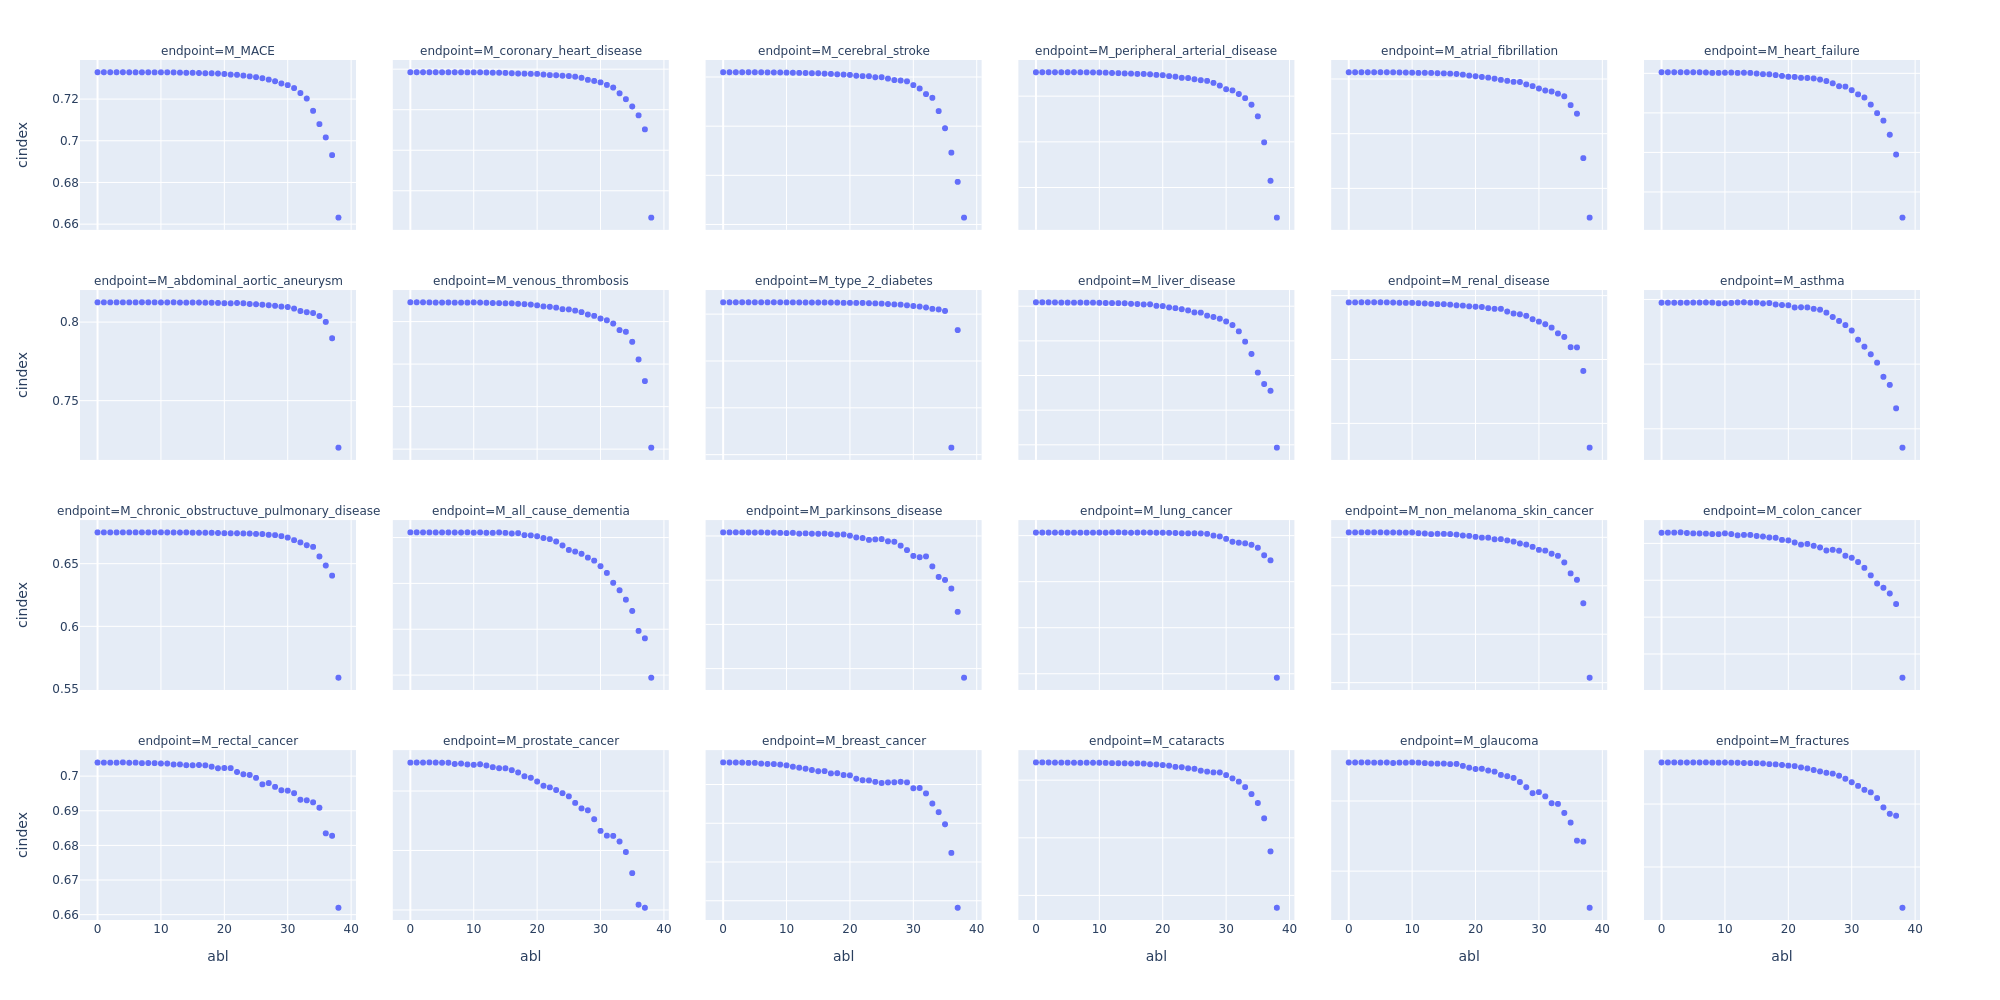

In [65]:
import plotly.express as px
t = pd.DataFrame().append(d_list)
df = px.data.iris() # iris is a pandas DataFrame
fig = px.scatter(t, x="abl", y="cindex",facet_col="endpoint", facet_col_wrap=6)
fig.update_yaxes(matches=None)
fig.show("png", width=2000, height=1000)

# General ablation - p-value

In [ ]:
def fit_cox(train, endpoint, penalizer, step_size):
    cph = CoxPHFitter(penalizer=penalizer)
    cph.fit(train, f"{endpoint}_event_time", f"{endpoint}_event", step_size=step_size, show_progress=False)
    return cph

In [ ]:
ray.shutdown()

In [ ]:
%env MKL_NUM_THREADS=1
%env NUMEXPR_NUM_THREADS=1
%env OMP_NUM_THREADS=1

In [ ]:
import ray

ray.init(num_cpus=10, dashboard_port=24762, dashboard_host="0.0.0.0", include_dashboard=True)#, webui_url="0.0.0.0"))

In [84]:
def prepare_covariates(endpoint, covariates):
    if endpoint == "M_type_2_diabetes":
        if "diabetes1" in covariates: covariates = [c for c in covariates if c!="diabetes1"]
        if "diabetes2" in covariates: covariates = [c for c in covariates if c!="diabetes2"]
    if endpoint in ["M_prostate_cancer", "M_ovarian_cancer", "M_breast_cancer", "M_uterus_cancer"]:
        if "sex" in covariates: covariates = [c for c in covariates if c!="sex"]
    return covariates

@ray.remote
def fit_abl_endpoint(endpoint, covariates, train_endpoint, module, feature_set, partition, cph_path):
    covariates = prepare_covariates(endpoint, covariates)
    try:
        cph = fit_cox(train_endpoint[covariates + [f"{endpoint}_event", f"{endpoint}_event_time"]], endpoint, penalizer=0.0, step_size=0.5)
        pickle.dump(cph, open(cph_path, "wb"))
        return cph.summary.assign(endpoint=endpoint)
    except ConvergenceError:
        print("ConvergenceError", module, endpoint, feature_set, partition, "problem: reduce step size")
        try:
            cph = fit_cox(train_endpoint[covariates + [f"{endpoint}_event", f"{endpoint}_event_time"]], endpoint, penalizer=0.0, step_size=0.1)
            pickle.dump(cph, open(cph_path, "wb"))
            return cph.summary.assign(endpoint=endpoint)
            print("ConvergenceError", module, endpoint, feature_set, partition, "trying with reduced step size ... successfull")
        except:
            print("ConvergenceError", module, endpoint, feature_set, partition, "trying with reduced step size ... failed")

In [ ]:
module="COX"
frame_dict = {}
features = {"COX": {"PANEL": PANEL}}
ep_labels = [f"{endpoint}_event" for endpoint in endpoints] + [f"{endpoint}_event_time" for endpoint in endpoints]
data_train = data_train_all[["eid", "partition", "split"]+ PANEL + ep_labels]  

for partition in partitions:
    train_partition = data_train.query("partition==@partition")
    for feature_set, covariates in features[module].items():
        abl_name = ""
        for abl in tqdm(list(range(len(covariates)))):
            print(abl)
            covariates = [c for c in covariates if c!=abl_name]
            abl_dfs = []
            for endpoint in tqdm(endpoints):
                eids_incl = eids_dict[endpoint] 
                train_endpoint = train_partition.query("eid==@eids_incl")
                cph_path = f"{dump_path}/{module}_{endpoint}_{feature_set}_{partition}_ablgeneralcoef{abl}.p"
                abl_dfs.append(fit_abl_endpoint.remote(endpoint, covariates, train_endpoint, module, feature_set, partition, cph_path))
            abl_df = pd.concat([ray.get(df) for df in abl_dfs], axis=0).reset_index()
            abl_name = abl_df.groupby("covariate")["coef", "p"].agg("mean").sort_values("p").iloc[-1].name

In [86]:
d_list_general = []
for endpoint in tqdm(endpoints):
    for abl in tqdm(list(range(len(PANEL)))):
        try:
            cph = pickle.load(open(f"{dump_path}/COX_{endpoint}_PANEL_0_ablgeneral{abl}.p", "rb"))
            d_list_general.append({"endpoint": endpoint, "abl": abl, "cindex": cph.concordance_index_, "cph": cph})
        except:
            pass

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

In [88]:
tg = pd.DataFrame().append(d_list_general)
tg

,endpoint,abl,cindex,cph
0,M_MACE,0,0.732868,<lifelines.CoxPHFitter: fitted with 76127 tota...
1,M_MACE,1,0.732868,<lifelines.CoxPHFitter: fitted with 76127 tota...
2,M_MACE,2,0.732879,<lifelines.CoxPHFitter: fitted with 76127 tota...
3,M_MACE,3,0.732872,<lifelines.CoxPHFitter: fitted with 76127 tota...
4,M_MACE,4,0.732783,<lifelines.CoxPHFitter: fitted with 76127 tota...
...,...,...,...,...
931,M_fractures,34,0.597478,<lifelines.CoxPHFitter: fitted with 87430 tota...
932,M_fractures,35,0.584068,<lifelines.CoxPHFitter: fitted with 87430 tota...
933,M_fractures,36,0.580769,<lifelines.CoxPHFitter: fitted with 87430 tota...
934,M_fractures,37,0.567372,<lifelines.CoxPHFitter: fitted with 87430 tota...


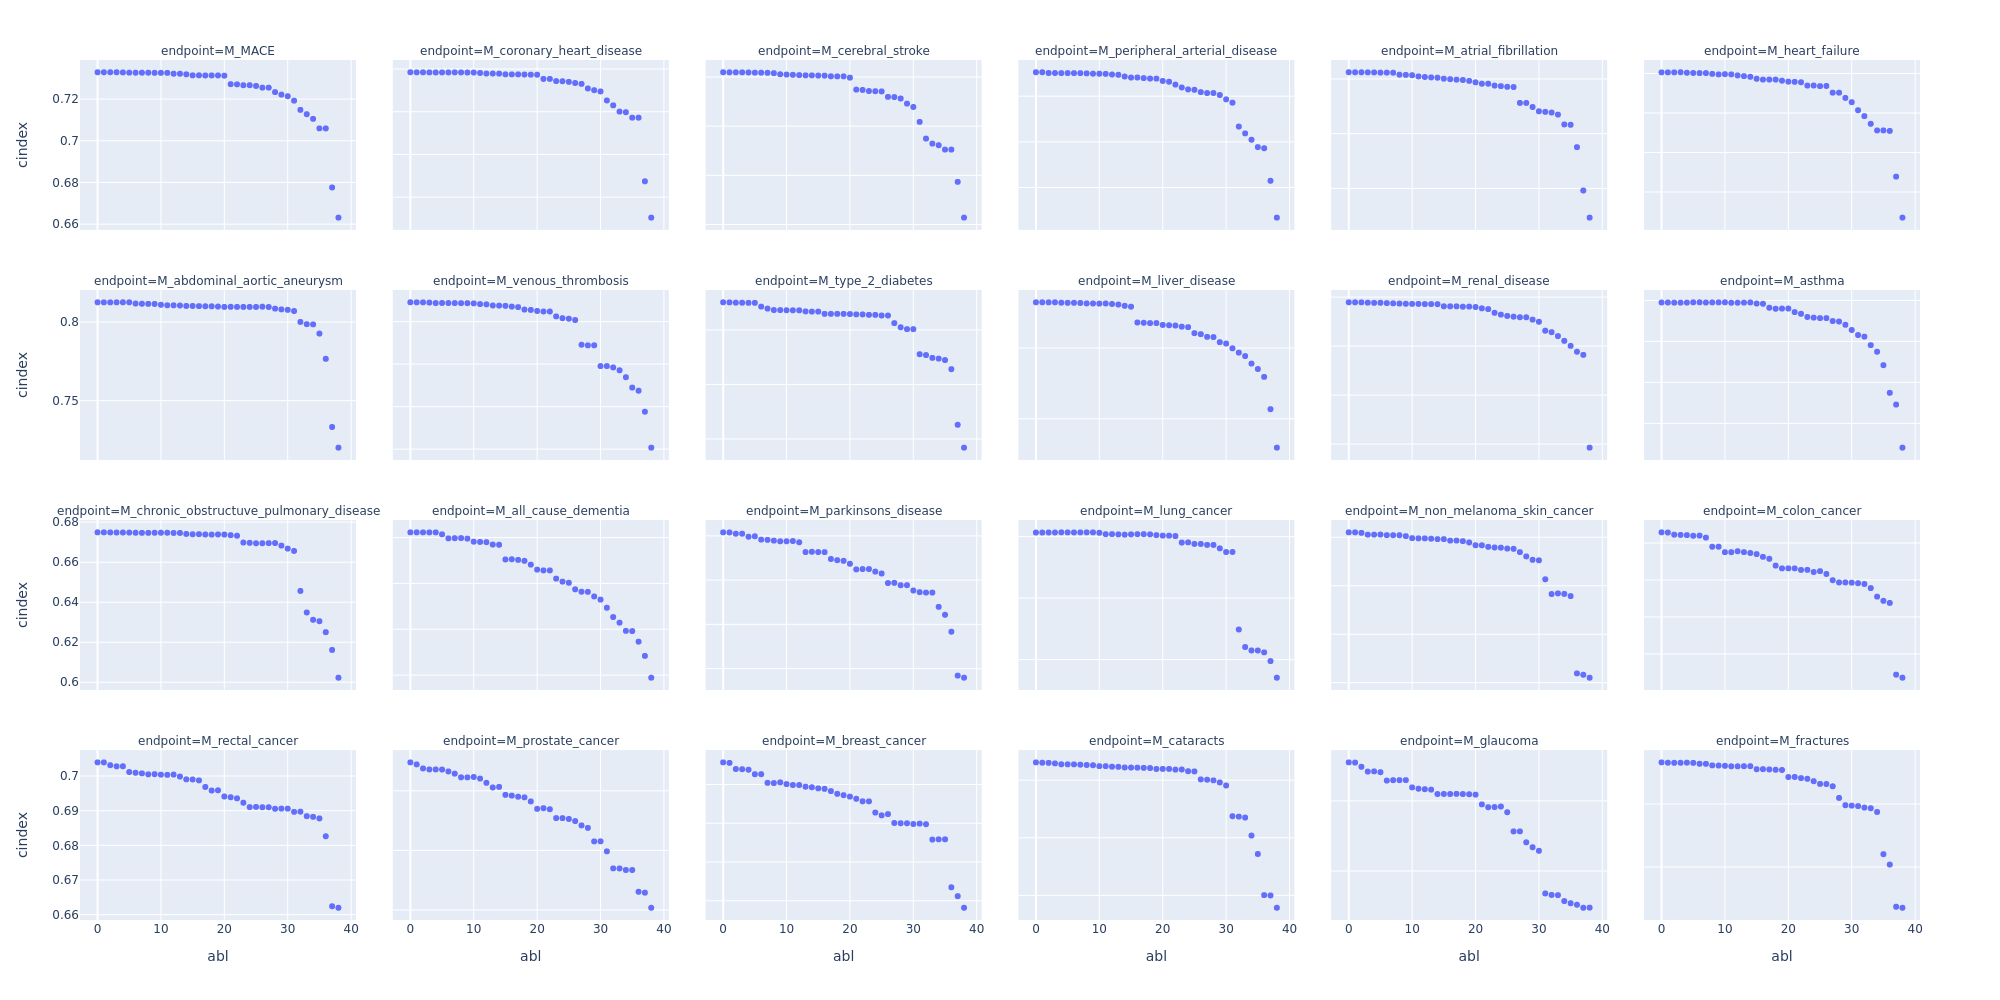

In [89]:
import plotly.express as px

fig = px.scatter(tg, x="abl", y="cindex",facet_col="endpoint", facet_col_wrap=6)
fig.update_yaxes(matches=None)
fig.show("png", width=2000, height=1000)

# General ablation - coef

In [ ]:
def fit_cox(train, endpoint, penalizer, step_size):
    cph = CoxPHFitter(penalizer=penalizer)
    cph.fit(train, f"{endpoint}_event_time", f"{endpoint}_event", step_size=step_size, show_progress=False)
    return cph

In [ ]:
ray.shutdown()

In [ ]:
%env MKL_NUM_THREADS=1
%env NUMEXPR_NUM_THREADS=1
%env OMP_NUM_THREADS=1

In [ ]:
import ray

ray.init(num_cpus=10, dashboard_port=24762, dashboard_host="0.0.0.0", include_dashboard=True)#, webui_url="0.0.0.0"))

In [176]:
def prepare_covariates(endpoint, covariates):
    if endpoint == "M_type_2_diabetes":
        if "diabetes1" in covariates: covariates = [c for c in covariates if c!="diabetes1"]
        if "diabetes2" in covariates: covariates = [c for c in covariates if c!="diabetes2"]
    if endpoint in ["M_prostate_cancer", "M_ovarian_cancer", "M_breast_cancer", "M_uterus_cancer"]:
        if "sex" in covariates: covariates = [c for c in covariates if c!="sex"]
    return covariates

@ray.remote
def fit_abl_partition(endpoint, covariates, train_endpoint, module, feature_set, partitions):
    dfs = []
    for partition in tqdm(partitions):
        train_partition = train_endpoint.query("partition==@partition")
        cph_path = f"{dump_path}/{module}_{endpoint}_{feature_set}_{partition}_ablgeneralcoefagg{abl}.p"
        covariates = prepare_covariates(endpoint, covariates)
        try:
            cph = fit_cox(train_endpoint[covariates + [f"{endpoint}_event", f"{endpoint}_event_time"]], endpoint, penalizer=0.0, step_size=0.5)
            pickle.dump(cph, open(cph_path, "wb"))
            dfs.append(cph.summary.assign(endpoint=endpoint))
        except ConvergenceError:
            print("ConvergenceError", module, endpoint, feature_set, partition, "problem: reduce step size")
            try:
                cph = fit_cox(train_endpoint[covariates + [f"{endpoint}_event", f"{endpoint}_event_time"]], endpoint, penalizer=0.0, step_size=0.1)
                pickle.dump(cph, open(cph_path, "wb"))
                dfs.append(cph.summary.assign(endpoint=endpoint))
                print("ConvergenceError", module, endpoint, feature_set, partition, "trying with reduced step size ... successfull")
            except:
                print("ConvergenceError", module, endpoint, feature_set, partition, "trying with reduced step size ... failed")
        return pd.concat(dfs, axis=0).reset_index()

In [178]:
partitions

(pid=2935890)   0%|          | 0/22 [00:00<?, ?it/s]


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

(pid=2935894) ConvergenceError COX M_type_2_diabetes PANEL 0 trying with reduced step size ... successfull
(pid=2935894)   0%|          | 0/22 [00:00<?, ?it/s]


In [ ]:
module="COX"
frame_dict = {}
features = {"COX": {"PANEL": PANEL}}
ep_labels = [f"{endpoint}_event" for endpoint in endpoints] + [f"{endpoint}_event_time" for endpoint in endpoints]
data_train = data_train_all[["eid", "partition", "split"]+ PANEL + ep_labels] 

def absmean(x): return x.abs().mean()

for feature_set, covariates in features[module].items():
    abl_name = ""
    for abl in tqdm(list(range(len(covariates)))):
        print(abl)
        covariates = [c for c in covariates if c!=abl_name]
        abl_dfs = []
        for endpoint in tqdm(endpoints):
            eids_incl = eids_dict[endpoint] 
            train_endpoint = data_train.query("eid==@eids_incl")
            dfs = fit_abl_partition.remote(endpoint, covariates, train_endpoint, module, feature_set, partitions)
            abl_dfs.append(dfs)
        abl_df = pd.concat([ray.get(df) for df in abl_dfs], axis=0).reset_index()
        abl_name = abl_df.groupby("covariate")["coef", "p"].agg(absmean).sort_values("coef", ascending=False).iloc[-1].name

  0%|          | 0/39 [00:00<?, ?it/s]

0


  0%|          | 0/24 [00:00<?, ?it/s]

(pid=2935892)   0%|          | 0/22 [00:00<?, ?it/s]


(pid=2935893) /home/steinfej/miniconda3/envs/riskiano_py39/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1777: RuntimeWarning: overflow encountered in exp
(pid=2935893)   scores = weights * exp(dot(X, beta))
(pid=2935893) /home/steinfej/miniconda3/envs/riskiano_py39/lib/python3.9/site-packages/numpy/core/_methods.py:48: RuntimeWarning: invalid value encountered in reduce
(pid=2935893)   return umr_sum(a, axis, dtype, out, keepdims, initial, where)
(pid=2935893) /home/steinfej/miniconda3/envs/riskiano_py39/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1849: RuntimeWarning: divide by zero encountered in log
(pid=2935893)   log_lik = log_lik + dot(x_death_sum, beta) + weighted_average * log(denom).sum()
(pid=2935893) /home/steinfej/miniconda3/envs/riskiano_py39/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1825: RuntimeWarning: invalid value encountered in multiply
(pid=2935893)   numer = risk_phi_x - multiply.outer(increasing_proportion, ti

(pid=2935894)   0%|          | 0/22 [00:00<?, ?it/s]
(pid=2935893) ConvergenceError COX M_type_2_diabetes PANEL 0 problem: reduce step size
(pid=2935894)   0%|          | 0/22 [00:00<?, ?it/s]
(pid=2935893) ConvergenceError COX M_type_2_diabetes PANEL 0 trying with reduced step size ... successfull
(pid=2935893)   0%|          | 0/22 [00:00<?, ?it/s]
1


  0%|          | 0/24 [00:00<?, ?it/s]

(pid=2935894)   0%|          | 0/22 [00:00<?, ?it/s]


(pid=2935887) /home/steinfej/miniconda3/envs/riskiano_py39/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1777: RuntimeWarning: overflow encountered in exp
(pid=2935887)   scores = weights * exp(dot(X, beta))
(pid=2935887) /home/steinfej/miniconda3/envs/riskiano_py39/lib/python3.9/site-packages/numpy/core/_methods.py:48: RuntimeWarning: invalid value encountered in reduce
(pid=2935887)   return umr_sum(a, axis, dtype, out, keepdims, initial, where)
(pid=2935887) /home/steinfej/miniconda3/envs/riskiano_py39/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1849: RuntimeWarning: divide by zero encountered in log
(pid=2935887)   log_lik = log_lik + dot(x_death_sum, beta) + weighted_average * log(denom).sum()
(pid=2935887) /home/steinfej/miniconda3/envs/riskiano_py39/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1825: RuntimeWarning: invalid value encountered in multiply
(pid=2935887)   numer = risk_phi_x - multiply.outer(increasing_proportion, ti

(pid=2935887) ConvergenceError COX M_type_2_diabetes PANEL 0 problem: reduce step size
(pid=2935890)   0%|          | 0/22 [00:00<?, ?it/s]
(pid=2935887) ConvergenceError COX M_type_2_diabetes PANEL 0 trying with reduced step size ... successfull
2


  0%|          | 0/24 [00:00<?, ?it/s]

(pid=2935893)   0%|          | 0/22 [00:00<?, ?it/s]


(pid=2935887) /home/steinfej/miniconda3/envs/riskiano_py39/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1777: RuntimeWarning: overflow encountered in exp
(pid=2935887)   scores = weights * exp(dot(X, beta))
(pid=2935887) /home/steinfej/miniconda3/envs/riskiano_py39/lib/python3.9/site-packages/numpy/core/_methods.py:48: RuntimeWarning: invalid value encountered in reduce
(pid=2935887)   return umr_sum(a, axis, dtype, out, keepdims, initial, where)
(pid=2935887) /home/steinfej/miniconda3/envs/riskiano_py39/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1849: RuntimeWarning: divide by zero encountered in log
(pid=2935887)   log_lik = log_lik + dot(x_death_sum, beta) + weighted_average * log(denom).sum()
(pid=2935887) /home/steinfej/miniconda3/envs/riskiano_py39/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1825: RuntimeWarning: invalid value encountered in multiply
(pid=2935887)   numer = risk_phi_x - multiply.outer(increasing_proportion, ti

(pid=2935887) ConvergenceError COX M_type_2_diabetes PANEL 0 problem: reduce step size
(pid=2935888)   0%|          | 0/22 [00:00<?, ?it/s]
(pid=2935887) ConvergenceError COX M_type_2_diabetes PANEL 0 trying with reduced step size ... successfull
(pid=2935887)   0%|          | 0/22 [00:00<?, ?it/s]
3


  0%|          | 0/24 [00:00<?, ?it/s]

(pid=2935888)   0%|          | 0/22 [00:00<?, ?it/s]


(pid=2935896) /home/steinfej/miniconda3/envs/riskiano_py39/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1777: RuntimeWarning: overflow encountered in exp
(pid=2935896)   scores = weights * exp(dot(X, beta))
(pid=2935896) /home/steinfej/miniconda3/envs/riskiano_py39/lib/python3.9/site-packages/numpy/core/_methods.py:48: RuntimeWarning: invalid value encountered in reduce
(pid=2935896)   return umr_sum(a, axis, dtype, out, keepdims, initial, where)
(pid=2935896) /home/steinfej/miniconda3/envs/riskiano_py39/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1849: RuntimeWarning: divide by zero encountered in log
(pid=2935896)   log_lik = log_lik + dot(x_death_sum, beta) + weighted_average * log(denom).sum()
(pid=2935896) /home/steinfej/miniconda3/envs/riskiano_py39/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1825: RuntimeWarning: invalid value encountered in multiply
(pid=2935896)   numer = risk_phi_x - multiply.outer(increasing_proportion, ti

(pid=2935893)   0%|          | 0/22 [00:00<?, ?it/s]
(pid=2935896) ConvergenceError COX M_type_2_diabetes PANEL 0 problem: reduce step size
(pid=2935887)   0%|          | 0/22 [00:00<?, ?it/s]
(pid=2935896) ConvergenceError COX M_type_2_diabetes PANEL 0 trying with reduced step size ... successfull


In [ ]:
def get_cph_score()

In [ ]:
partition=[0]
d_list_general = []
for endpoint in tqdm(endpoints):
    eids = eids_dict[endpoint]
    data_endpoint = data_test_all.query("eid==@eids")
    for partition in partitions:
        data_partition = data_endpoint.query("partition==@partition")
        for abl in tqdm(list(range(len(PANEL)))):
            #try:
            cph = pickle.load(open(f"{dump_path}/COX_{endpoint}_PANEL_{partition}_ablgeneralcoef{abl}.p", "rb"))
            cindex = cph.score(data_partition, scoring_method="concordance_index")
            print(cindex)
            d_list_general.append({"endpoint": endpoint, "abl": abl, "cindex": cindex, "cph": cph})
            #except:
               # pass

In [165]:
tgc = pd.DataFrame().append(d_list_general).assign(rank = lambda x: 38- x.abl)
tgc

,endpoint,abl,cindex,cph,rank
0,M_MACE,0,0.729401,<lifelines.CoxPHFitter: fitted with 76127 tota...,38
1,M_MACE,1,0.729524,<lifelines.CoxPHFitter: fitted with 76127 tota...,37
2,M_MACE,2,0.729638,<lifelines.CoxPHFitter: fitted with 76127 tota...,36
3,M_MACE,3,0.729754,<lifelines.CoxPHFitter: fitted with 76127 tota...,35
4,M_MACE,4,0.729743,<lifelines.CoxPHFitter: fitted with 76127 tota...,34
...,...,...,...,...,...
931,M_fractures,34,0.596918,<lifelines.CoxPHFitter: fitted with 87430 tota...,4
932,M_fractures,35,0.596778,<lifelines.CoxPHFitter: fitted with 87430 tota...,3
933,M_fractures,36,0.577519,<lifelines.CoxPHFitter: fitted with 87430 tota...,2
934,M_fractures,37,0.577483,<lifelines.CoxPHFitter: fitted with 87430 tota...,1


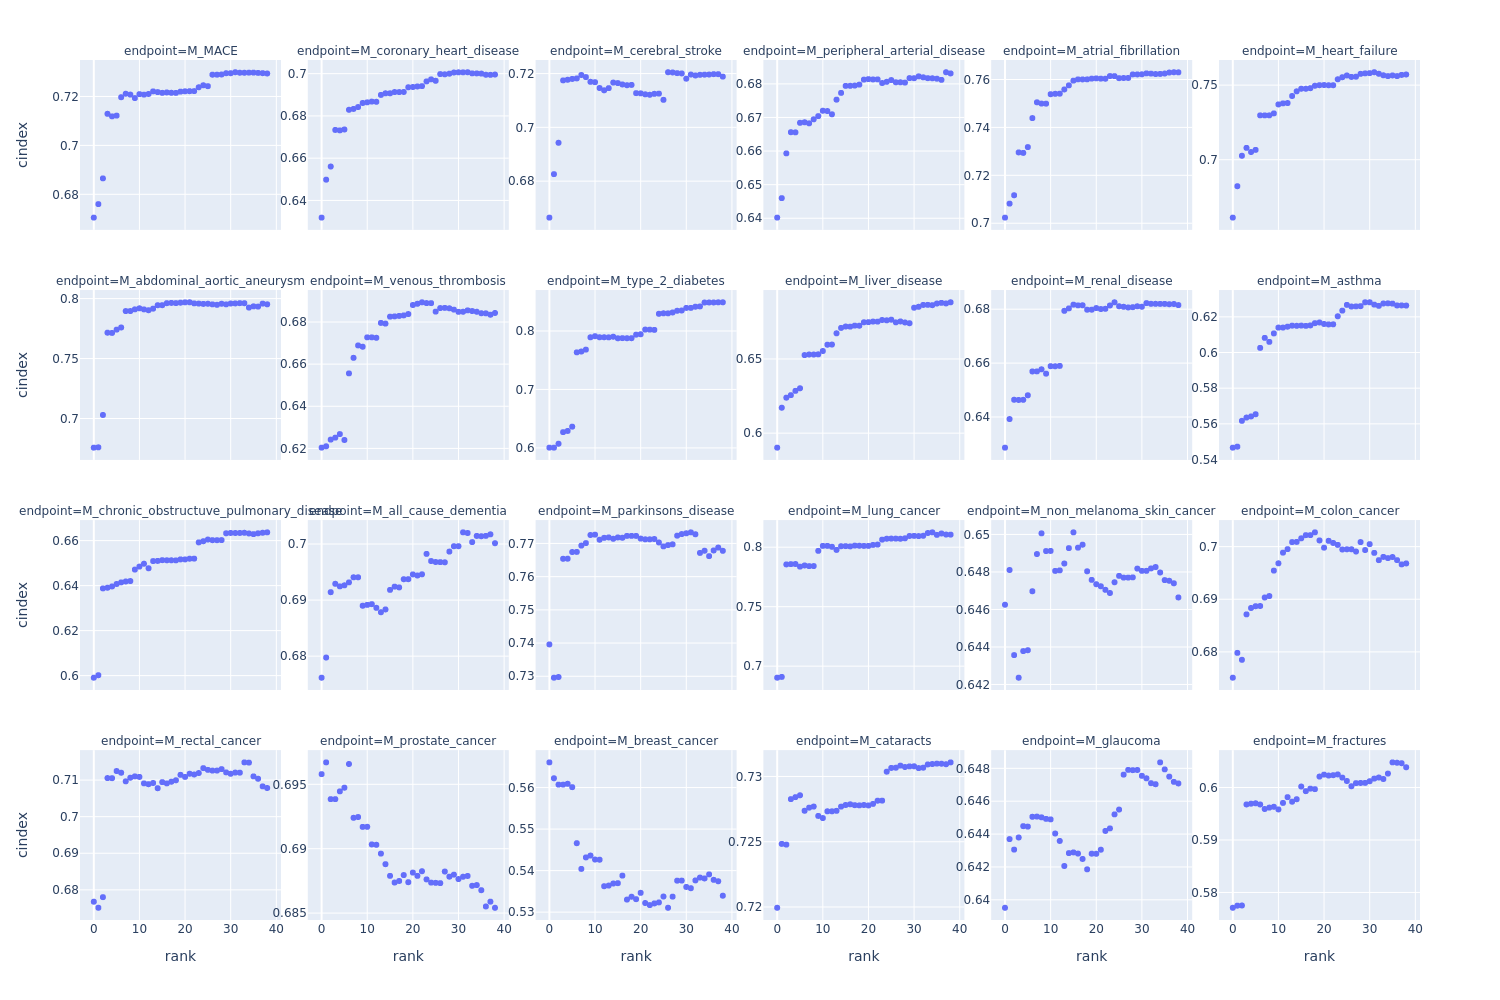

In [168]:
import plotly.express as px

fig = px.scatter(tgc, x="rank", y="cindex",facet_col="endpoint", facet_col_wrap=6)
fig.update_yaxes(matches=None)
for i in [2, 3, 4, 5, 6]:
    fig.update_yaxes(showticklabels=True, col=i) 
fig.show("png", width=1500, height=1000)

In [143]:
x = tgc.query("endpoint=='M_MACE'")
covs = []
for i, rank in zip(list(range(len(x)))[::-1], list(range(len(x)))):
    cph = x["cph"].iloc[i]
    cov_list = cph.summary.index.to_list()
    cov_diff = [c for c in cov_list if not c in covs][0]
    covs.append(cov_diff)
    print(rank, cov_diff)

0 age_at_recruitment
1 diabetes2
2 smoking_status_2.0
3 sex
4 daily_healthy_food
5 antihypertensives
6 body_mass_index_bmi
7 weight
8 standing_height
9 waist_hip_ratio
10 cholesterol
11 ldl_direct
12 waist_circumference
13 cystatin_c
14 creatinine
15 red_blood_cell_erythrocyte_count
16 haematocrit_percentage
17 mean_corpuscular_volume
18 haemoglobin_concentration
19 hdl_cholesterol
20 alcohol_intake_frequency_2.0
21 fh_diabetes
22 mean_corpuscular_haemoglobin
23 education_years
24 glycated_haemoglobin_hba1c
25 albumin
26 systolic_blood_pressure
27 mean_corpuscular_haemoglobin_concentration
28 urate
29 white_blood_cell_leukocyte_count
30 alanine_aminotransferase
31 aspartate_aminotransferase
32 triglycerides
33 urea
34 glucose
35 platelet_count
36 alkaline_phosphatase
37 creactive_protein
38 daily_physical_activity


In [139]:
covs

[['age_at_recruitment'],
 ['age_at_recruitment', 'diabetes2'],
 ['age_at_recruitment', 'smoking_status_2.0', 'diabetes2'],
 ['age_at_recruitment', 'sex', 'smoking_status_2.0', 'diabetes2'],
 ['age_at_recruitment',
  'sex',
  'smoking_status_2.0',
  'daily_healthy_food',
  'diabetes2'],
 ['age_at_recruitment',
  'sex',
  'smoking_status_2.0',
  'daily_healthy_food',
  'diabetes2',
  'antihypertensives'],
 ['age_at_recruitment',
  'sex',
  'smoking_status_2.0',
  'daily_healthy_food',
  'diabetes2',
  'body_mass_index_bmi',
  'antihypertensives'],
 ['age_at_recruitment',
  'sex',
  'smoking_status_2.0',
  'daily_healthy_food',
  'diabetes2',
  'body_mass_index_bmi',
  'weight',
  'antihypertensives'],
 ['age_at_recruitment',
  'sex',
  'smoking_status_2.0',
  'daily_healthy_food',
  'diabetes2',
  'body_mass_index_bmi',
  'weight',
  'standing_height',
  'antihypertensives'],
 ['age_at_recruitment',
  'sex',
  'smoking_status_2.0',
  'daily_healthy_food',
  'diabetes2',
  'body_mass_inde

In [135]:
list(range(len(x))).reverse()

In [126]:
i=0
x.iloc[0]["cph"]

endpoint                                               M_MACE
abl                                                         0
cindex                                               0.732868
cph         <lifelines.CoxPHFitter: fitted with 76127 tota...
Name: 0, dtype: object

In [117]:
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p)
covariate,,,,,,,,,,
age_at_recruitment,0.242818,1.274837,0.013087,0.217168,0.268468,1.242552,1.30796,18.553844,7.592328e-77,252.863921


In [76]:
abl_df.groupby("covariate")["coef", "p"].agg("mean").sort_values("coef")

,coef,p
covariate,,
daily_healthy_food,-0.154508,0.237262
haematocrit_percentage,-0.131137,0.430431
sex,-0.095783,0.122084
creatinine,-0.055647,0.144047
education_years,-0.049690,0.201190
albumin,-0.039410,0.183543
mean_corpuscular_haemoglobin_concentration,-0.035494,0.567495
cholesterol,-0.034353,0.508824
hdl_cholesterol,-0.024236,0.380162


In [ ]:
from lifelines import CoxPHFitter
from dask.diagnostics import ProgressBar
from lifelines.exceptions import ConvergenceError
import pickle

def flatten_dict(features):
    df = pd.json_normalize(d, sep='_')
    t = list(df.to_dict(orient='records')[0].values())
    flat_list = [item for sublist in t for item in sublist]
    return list(set(flat_list))

def flatten_list(l):
    return [item for sublist in l for item in sublist]

def get_all_features(metabolomics, endpoints):
    f_dicts = flatten_list([[ds for ds in get_features(metabolomics, endpoint).values()] for endpoint in endpoints])
    fs = list(sorted(set(flatten_list(flatten_list([list(p.values()) for p in f_dicts])))))
    return fs + [f"{endpoint}_event" for endpoint in endpoints] + [f"{endpoint}_event_time" for endpoint in endpoints]

def get_features(metabolomics, endpoint):
    features = {"COX": {"Metabolomics": metabolomics,
                        "Age+Sex": AgeSex, 
                        "PANEL": PANEL,
                        "FRS": FRS,
                        "SCORE": SCORE,
                        "SCORE2": SCORE2,
                        "ASCVD": ASCVD,
                        "QRISK3": QRISK3
                       },
                "PCA": {"Metabolomics": [f'NMR_PCA{i}' for i in range(10)]},
                
                "DS":  {"Metabolomics": [f"logh_{endpoint}_Metabolomics"], 
                        "Age+Sex+Metabolomics": AgeSex+[f"logh_{endpoint}_Metabolomics"], 
                        "PANEL+Metabolomics": PANEL+[f"logh_{endpoint}_Metabolomics"],
                        "FRS+Metabolomics": FRS+[f"logh_{endpoint}_Metabolomics"],
                        "SCORE+Metabolomics": SCORE+[f"logh_{endpoint}_Metabolomics"],
                        "SCORE2+Metabolomics": SCORE2+[f"logh_{endpoint}_Metabolomics"],
                       "ASCVD+Metabolomics": ASCVD+[f"logh_{endpoint}_Metabolomics"],
                        "QRISK3+Metabolomics": QRISK3+[f"logh_{endpoint}_Metabolomics"]
                       }
               }
    
    return features
    
def fit_cox(train, endpoint, penalizer, step_size):
    cph = CoxPHFitter(penalizer=penalizer)
    cph.fit(train, f"{endpoint}_event_time", f"{endpoint}_event", step_size=step_size, show_progress=True)
    return cph

@ray.remote
def fit_partition(train_partition, endpoint, module, features, partition):
    for feature_set, covariates in tqdm(features[module].items()):
        cph_path = f"{dump_path}/{module}_{endpoint}_{feature_set}_{partition}.p"
        if endpoint == "M_type_2_diabetes":
            if "diabetes1" in covariates: covariates = [c for c in covariates if c!="diabetes1"]
            if "diabetes2" in covariates: covariates = [c for c in covariates if c!="diabetes2"]
        if endpoint in ["M_prostate_cancer", "M_ovarian_cancer", "M_breast_cancer", "M_uterus_cancer"]:
            if "sex" in covariates: covariates = [c for c in covariates if c!="sex"]
        if not os.path.isfile(cph_path):
            try:
                cph = fit_cox(train_partition[covariates + [f"{endpoint}_event", f"{endpoint}_event_time"]], endpoint, penalizer=0.0, step_size=0.5)
                pickle.dump(cph, open(cph_path, "wb"))
            except ConvergenceError:
                print("ConvergenceError", module, endpoint, feature_set, partition, "problem: reduce step size")
                try:
                    cph = fit_cox(train_partition[covariates + [f"{endpoint}_event", f"{endpoint}_event_time"]], endpoint, penalizer=0.0, step_size=0.1)
                    pickle.dump(cph, open(cph_path, "wb"))
                    print("ConvergenceError", module, endpoint, feature_set, partition, "trying with reduced step size ... successfull")
                except:
                    print("ConvergenceError", module, endpoint, feature_set, partition, "trying with reduced step size ... failed")
    return True

def train_cox(endpoints, modules, partitions, data_train):
    frame_dict = {}
    features_all = get_all_features(metabolomics, endpoints)
    data_train = data_train[["eid", "partition", "split"]+features_all]
    with ProgressBar():   
        for module in tqdm(modules):
            for endpoint in tqdm(endpoints):
                features = get_features(metabolomics, endpoint)
                eids_incl = eids_dict[endpoint] 
                train_endpoint = data_train.query("eid==@eids_incl")
                for partition in partitions:
                    train_partition = train_endpoint.query("partition==@partition")
                    frame_dict[f"{module}_{endpoint}_{partition}"] = fit_partition.remote(train_partition, endpoint, module, features, partition)
                    del train_partition
    return frame_dict

In [34]:
cph

NameError: name 'cph' is not defined

In [56]:
ray.shutdown()

In [57]:
endpoints

['M_MACE',
 'M_coronary_heart_disease',
 'M_cerebral_stroke',
 'M_peripheral_arterial_disease',
 'M_atrial_fibrillation',
 'M_heart_failure',
 'M_abdominal_aortic_aneurysm',
 'M_venous_thrombosis',
 'M_type_2_diabetes',
 'M_liver_disease',
 'M_renal_disease',
 'M_asthma',
 'M_chronic_obstructuve_pulmonary_disease',
 'M_all_cause_dementia',
 'M_parkinsons_disease',
 'M_lung_cancer',
 'M_non_melanoma_skin_cancer',
 'M_colon_cancer',
 'M_rectal_cancer',
 'M_prostate_cancer',
 'M_breast_cancer',
 'M_cataracts',
 'M_glaucoma',
 'M_fractures']

In [ ]:
frame_dict = train_cox(endpoints, modules, partitions, data_train)
    #["M_type_2_diabetes"],#,

Iteration 5: norm_delta = 0.03061, step_size = 0.8450, log_lik = -101087.13564, newton_decrement = 2.59601, seconds_since_start = 1.3
Iteration 2: norm_delta = 0.18743, step_size = 0.5000, log_lik = -77305.88467, newton_decrement = 144.74163, seconds_since_start = 0.7
Iteration 4: norm_delta = 0.15545, step_size = 0.6500, log_lik = -98832.25301, newton_decrement = 63.28741, seconds_since_start = 1.4
Iteration 1: norm_delta = 0.33484, step_size = 0.5000, log_lik = -78338.24458, newton_decrement = 506.39572, seconds_since_start = 0.2
Iteration 4: norm_delta = 0.03435, step_size = 0.6500, log_lik = -77176.13606, newton_decrement = 4.85783, seconds_since_start = 0.9
Iteration 4: norm_delta = 0.14113, step_size = 0.6500, log_lik = -102870.36533, newton_decrement = 62.39711, seconds_since_start = 1.0
Iteration 2: norm_delta = 0.48125, step_size = 0.5000, log_lik = -103738.18849, newton_decrement = 988.37984, seconds_since_start = 0.5
Iteration 1: norm_delta = 0.33288, step_size = 0.5000, log

In [ ]:
ray.shutdown()

## Check COX Convergence

In [160]:
endpoint = "M_liver_disease"
met =  [f"logh_{endpoint}_Metabolomics"]

In [173]:
from lifelines import CoxPHFitter
def fit_cox2(train, endpoint, penalizer=None, elastic=None, step_size=1):
    if penalizer is None: penalizer=0.0
    if elastic: 
        l1_ratio=0.5
        cph = CoxPHFitter(penalizer=penalizer, l1_ratio=l1_ratio)
    cph = CoxPHFitter()
    cph.fit(train, f"{endpoint}_event_time", f"{endpoint}_event", show_progress=True, step_size=step_size)
    return cph

In [174]:
sets = {#"met": met,
    "metabolomics":metabolomics, 
       # "AgeSex":AgeSex, 
      #  "AgeSex+met":AgeSex+met, 
      #  "AgeSex+metabolomics":AgeSex+metabolomics, 
     #   "ASCVD":ASCVD, 
     #   "ASCVD+met": ASCVD+met, 
     #   "ASCVD+metabolomics": ASCVD+metabolomics, 
        "PANEL":PANEL, 
        "PANEL+met":PANEL+met,
     #  "PANEL+metabolomics":PANEL+metabolomics
}

In [180]:
for set_name, set_cols in sets.items():
    print(set_name)
    step_size=0.5
   # if set_name.endswith("+metabolomics"): 
    #    elastic=True
    #    penalizer=0.001
    #    cph = fit_cox2(data_all.query("partition==1&split=='train'")[set_cols + [f"{endpoint}_event", f"{endpoint}_event_time"]], endpoint,
    #                   penalizer=penalizer, elastic=elastic, step_size=step_size)
    cph = fit_cox2(data_all.query("partition==1&split=='train'")[set_cols + [f"{endpoint}_event", f"{endpoint}_event_time"]], endpoint, step_size=step_size)
    print(cph.concordance_index_)
    #display(cph.variance_matrix_)
    cph.print_summary()

metabolomics
Iteration 1: norm_delta = 541.16993, step_size = 0.5000, log_lik = -63050.11401, newton_decrement = 1948.59933, seconds_since_start = 1.3
Iteration 2: norm_delta = 333.75497, step_size = 0.0500, log_lik = -62860.46409, newton_decrement = 1535.47246, seconds_since_start = 2.7
Iteration 3: norm_delta = 326.65849, step_size = 0.0065, log_lik = -62840.56802, newton_decrement = 1502.05204, seconds_since_start = 4.0
Iteration 4: norm_delta = 325.49595, step_size = 0.0011, log_lik = -62837.26982, newton_decrement = 1496.54829, seconds_since_start = 5.4
Iteration 5: norm_delta = 325.30050, step_size = 0.0002, log_lik = -62836.71422, newton_decrement = 1495.62214, seconds_since_start = 6.7
Iteration 6: norm_delta = 325.26745, step_size = 0.0000, log_lik = -62836.62037, newton_decrement = 1495.46573, seconds_since_start = 8.0
Iteration 7: norm_delta = 325.26184, step_size = 0.0000, log_lik = -62836.60451, newton_decrement = 1495.43930, seconds_since_start = 9.4
Convergence failed. S

<lifelines.CoxPHFitter: fitted with 96936 total observations, 91393 right-censored observations>
             duration col = 'M_liver_disease_event_time'
                event col = 'M_liver_disease_event'
      baseline estimation = breslow
   number of observations = 96936
number of events observed = 5543
   partial log-likelihood = -62836.60
         time fit was run = 2021-10-06 08:22:10 UTC

---
                                                                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                                                              
NMR_3hydroxybutyrate                                                            -0.01       0.99       0.04            -0.07             0.06                 0.93                 1.07
NMR_acetate                                                                      0.01       1.01       0.01            -0.02             0.03                 0.98                 1.04
NMR_acetoacetate                                                                -0.00       1.00       0.03            -0.06             0.06                 0.94                 1.06
NMR_acetone                                                                      0.01       1.01       0.03            -0.04             0.06                 0.96                 1.06
NMR_alanine                                                                      0.00       1.00       0.02            -0.03             0.04                 0.97                 1.04
NMR_albumin                                                                     -0.00       1.00       0.02            -0.05             0.04                 0.95                 1.04
NMR_apolipoprotein_a1                                                           -0.01       0.99       2.99            -5.86             5.85                 0.00               347.01
NMR_apolipoprotein_b                                                             0.65       1.92       4.89            -8.93            10.23                 0.00             27621.88
NMR_average_diameter_for_hdl_particles                                           0.00       1.00       0.02            -0.03             0.04                 0.97                 1.04
NMR_average_diameter_for_ldl_particles                                           0.01       1.01       0.11            -0.21             0.24                 0.81                 1.27
NMR_average_diameter_for_vldl_particles                                         -0.00       1.00       0.02            -0.04             0.04                 0.96                 1.04
NMR_cholesterol_in_chylomicrons_and_extremely_large_vldl                        -2.64       0.07      11.12           -24.43            19.15                 0.00             2.08e+08
NMR_cholesterol_in_idl                                                           0.06       1.06       9.06           -17.69            17.81                 0.00             5.43e+07
NMR_cholesterol_in_large_hdl                                                     1.85       6.34      19.58           -36.53            40.23                 0.00             2.95e+17
NMR_cholesterol_in_large_ldl                                                    -8.47       0.00      22.79           -53.14            36.21                 0.00             5.30e+15
NMR_cholesterol_in_large_vldl                                                   -3.15       0.04      25.02           -52.18            45.89                 0.00             8.49e+19
NMR_cholesterol_in_medium_hdl                                                    5.32     203.87      25.95           -45.54            56.17                 0.00             2.48e+24
NMR_cholesterol_in_medium_ldl                                                   -2.91       0.05    

PANEL
Iteration 1: norm_delta = 1.01214, step_size = 0.5000, log_lik = -63050.11401, newton_decrement = 2311.40288, seconds_since_start = 0.4
Iteration 2: norm_delta = 0.69504, step_size = 0.5000, log_lik = -68730.06678, newton_decrement = 7565.71856, seconds_since_start = 0.8
Iteration 3: norm_delta = 0.38337, step_size = 0.5000, log_lik = -63466.02648, newton_decrement = 1195.10691, seconds_since_start = 1.2
Iteration 4: norm_delta = 0.07030, step_size = 0.6500, log_lik = -62359.87866, newton_decrement = 434.04572, seconds_since_start = 1.5
Iteration 5: norm_delta = 0.04978, step_size = 0.8450, log_lik = -61873.75482, newton_decrement = 151.59866, seconds_since_start = 1.9
Iteration 6: norm_delta = 0.03820, step_size = 1.0000, log_lik = -61685.64040, newton_decrement = 44.16098, seconds_since_start = 2.3
Iteration 7: norm_delta = 0.02487, step_size = 1.0000, log_lik = -61631.89532, newton_decrement = 8.92795, seconds_since_start = 2.7
Iteration 8: norm_delta = 0.00799, step_size = 1.

<lifelines.CoxPHFitter: fitted with 96936 total observations, 91393 right-censored observations>
             duration col = 'M_liver_disease_event_time'
                event col = 'M_liver_disease_event'
      baseline estimation = breslow
   number of observations = 96936
number of events observed = 5543
   partial log-likelihood = -61621.07
         time fit was run = 2021-10-06 08:22:23 UTC

---
                                             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                          
age_at_recruitment                           0.10       1.11       0.02             0.07             0.14                 1.07                 1.15
sex                                          0.22       1.25       0.05             0.12             0.33                 1.13                 1.38
smoking_status_2.0                           0.21       1.24       0.04             0.13             0.29                 1.14                 1.34
alcohol_intake_frequency_2.0                 0.03       1.03       0.04            -0.04             0.10                 0.96                 1.11
daily_physical_activity                     -0.03       0.97       0.01            -0.06            -0.00                 0.95                 1.00
education_years                             -0.07       0.93       0.01            -0.10            -0.05                 0.91                 0.95
daily_healthy_food                          -0.27       0.76       0.09            -0.45            -0.10                 0.64                 0.91
fh_diabetes                                  0.06       1.06       0.04            -0.01             0.13                 0.99                 1.14
diabetes2                                    0.29       1.33       0.06             0.17             0.40                 1.19                 1.49
body_mass_index_bmi                          0.14       1.15       0.10            -0.06             0.33                 0.94                 1.40
waist_hip_ratio                              0.20       1.22       0.03             0.14             0.26                 1.15                 1.30
waist_circumference                          0.02       1.02       0.05            -0.08             0.12                 0.92                 1.13
weight                                      -0.13       0.88       0.12            -0.36             0.10                 0.70                 1.10
standing_height                              0.05       1.05       0.07            -0.08             0.19                 0.92                 1.21
systolic_blood_pressure                      0.01       1.01       0.01            -0.02             0.03                 0.98                 1.04
cholesterol                                 -0.07       0.93       0.07            -0.22             0.08                 0.81                 1.08
ldl_direct                                  -0.04       0.96       0.07            -0.17             0.09                 0.84                 1.09
hdl_cholesterol                             -0.00       1.00       0.03            -0.06             0.06                 0.94                 1.06
triglycerides                                0.06       1.06       0.02             0.02             0.09                 1.02                 1.10
glucose                                      0.02       1.02       0.01            -0.00             0.05                 1.00                 1.05
glycated_haemoglobin_hba1c                   0.01       1.01       0.02            -0.03             0.04                 0.98                 1.04
creatinine                                  -0.11       0.90       0.02            -0.14            -0.07                 0.87                 0.93
cystatin_c                                  

PANEL+met
Iteration 1: norm_delta = 1.04252, step_size = 0.5000, log_lik = -63050.11401, newton_decrement = 2451.59656, seconds_since_start = 0.4
Iteration 2: norm_delta = 0.55272, step_size = 0.5000, log_lik = -66568.02856, newton_decrement = 4465.13574, seconds_since_start = 0.8
Iteration 3: norm_delta = 0.22521, step_size = 0.5000, log_lik = -63289.50388, newton_decrement = 1158.25217, seconds_since_start = 1.2
Iteration 4: norm_delta = 0.08654, step_size = 0.6500, log_lik = -62209.38220, newton_decrement = 446.57269, seconds_since_start = 1.6
Iteration 5: norm_delta = 0.06730, step_size = 0.8450, log_lik = -61708.47435, newton_decrement = 160.16180, seconds_since_start = 2.0
Iteration 6: norm_delta = 0.06110, step_size = 1.0000, log_lik = -61508.75407, newton_decrement = 49.99275, seconds_since_start = 2.4
Iteration 7: norm_delta = 0.03417, step_size = 1.0000, log_lik = -61447.65038, newton_decrement = 10.68632, seconds_since_start = 2.8
Iteration 8: norm_delta = 0.00971, step_size

<lifelines.CoxPHFitter: fitted with 96936 total observations, 91393 right-censored observations>
             duration col = 'M_liver_disease_event_time'
                event col = 'M_liver_disease_event'
      baseline estimation = breslow
   number of observations = 96936
number of events observed = 5543
   partial log-likelihood = -61434.55
         time fit was run = 2021-10-06 08:22:30 UTC

---
                                             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                          
age_at_recruitment                           0.06       1.06       0.02             0.03             0.09                 1.03                 1.10
sex                                          0.21       1.23       0.05             0.11             0.31                 1.11                 1.37
smoking_status_2.0                           0.14       1.15       0.04             0.06             0.22                 1.06                 1.25
alcohol_intake_frequency_2.0                -0.04       0.96       0.04            -0.11             0.03                 0.90                 1.03
daily_physical_activity                     -0.02       0.98       0.01            -0.05             0.01                 0.95                 1.01
education_years                             -0.06       0.94       0.01            -0.09            -0.03                 0.92                 0.97
daily_healthy_food                          -0.22       0.80       0.09            -0.40            -0.04                 0.67                 0.96
fh_diabetes                                  0.06       1.06       0.04            -0.01             0.13                 0.99                 1.14
diabetes2                                    0.25       1.28       0.06             0.13             0.36                 1.14                 1.43
body_mass_index_bmi                          0.12       1.13       0.10            -0.08             0.32                 0.93                 1.37
waist_hip_ratio                              0.17       1.18       0.03             0.10             0.23                 1.11                 1.26
waist_circumference                          0.00       1.00       0.05            -0.10             0.11                 0.91                 1.11
weight                                      -0.13       0.88       0.12            -0.36             0.10                 0.70                 1.10
standing_height                              0.07       1.07       0.07            -0.06             0.21                 0.94                 1.23
systolic_blood_pressure                     -0.02       0.98       0.01            -0.04             0.01                 0.96                 1.01
cholesterol                                  0.01       1.01       0.07            -0.14             0.15                 0.87                 1.17
ldl_direct                                  -0.01       0.99       0.07            -0.14             0.12                 0.87                 1.12
hdl_cholesterol                              0.03       1.03       0.03            -0.03             0.08                 0.97                 1.09
triglycerides                               -0.06       0.95       0.02            -0.09            -0.02                 0.91                 0.98
glucose                                     -0.01       0.99       0.01            -0.04             0.01                 0.96                 1.01
glycated_haemoglobin_hba1c                  -0.02       0.98       0.02            -0.05             0.01                 0.95                 1.01
creatinine                                  -0.10       0.91       0.02            -0.13            -0.06                 0.88                 0.94
cystatin_c                                  

## Check correlations

In [134]:
train_partition = data_train.query("partition==0")[PANEL+ [f"{endpoint}_event", f"{endpoint}_event_time"] + [f"logh_{endpoint}_Metabolomics" for endpoint in endpoints]]
train_partition

,age_at_recruitment,sex,smoking_status_2.0,alcohol_intake_frequency_2.0,daily_physical_activity,education_years,daily_healthy_food,fh_diabetes,diabetes2,body_mass_index_bmi,...,logh_M_oesophagus_cancer_Metabolomics,logh_M_colon_cancer_Metabolomics,logh_M_rectal_cancer_Metabolomics,logh_M_prostate_cancer_Metabolomics,logh_M_ovarian_cancer_Metabolomics,logh_M_breast_cancer_Metabolomics,logh_M_uterus_cancer_Metabolomics,logh_M_cataracts_Metabolomics,logh_M_glaucoma_Metabolomics,logh_M_fractures_Metabolomics
0,-1.669439,0.0,0,0,-0.759626,-1.801654,1.0,False,False,0.400134,...,0.635621,0.279620,0.398328,0.220764,0.219591,0.216270,0.209314,-0.152583,-0.044007,-0.512342
1,0.060909,1.0,0,0,-0.035916,0.867819,1.0,False,False,-1.527496,...,-0.350578,-0.396176,-0.523375,-0.742203,-0.767338,-0.773011,-0.777873,0.269122,0.238755,1.008776
2,-0.804265,1.0,0,0,0.481020,-1.038947,1.0,False,False,-0.988981,...,-1.103233,-0.744068,-1.032355,-0.726476,-0.738086,-0.743493,-0.772565,-0.573454,-0.464902,0.774711
3,-1.298650,1.0,0,0,0.481020,0.105112,1.0,False,False,-0.063279,...,-0.699158,-0.492378,-0.307046,-0.410113,-0.415698,-0.416866,-0.455736,-0.637123,-0.357146,0.271763
4,-1.793036,0.0,1,0,-0.759626,-0.657594,1.0,False,False,-1.447412,...,-1.098667,-0.476304,-0.535228,-0.706395,-0.691780,-0.738420,-0.742235,-1.213267,-0.547056,-0.308849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107208,-1.051458,1.0,0,1,-0.759626,0.867819,1.0,False,False,-0.462492,...,0.038454,-0.553762,-0.374870,-0.031123,-0.046292,0.009302,-0.042056,-0.442788,-0.088426,0.064021
107209,0.060909,1.0,1,1,-0.759626,-0.657594,1.0,False,False,-0.177257,...,1.075957,0.893629,0.440261,0.956743,0.952902,0.986831,1.024413,1.035189,0.302510,2.014183
107210,0.678890,1.0,0,0,-0.759626,-0.657594,1.0,False,False,0.100829,...,0.157885,0.361105,0.443325,-0.114331,-0.079182,-0.127183,-0.032105,0.587991,0.590949,0.733048
107211,1.049679,1.0,0,1,-0.604545,0.867819,1.0,False,False,-1.071504,...,-0.826715,-0.705075,-0.899840,-0.986580,-1.014701,-1.029624,-1.039804,-0.657419,-0.438266,0.513973


In [135]:
dfCorr = train_partition.corr().abs()

In [136]:
import seaborn as sn

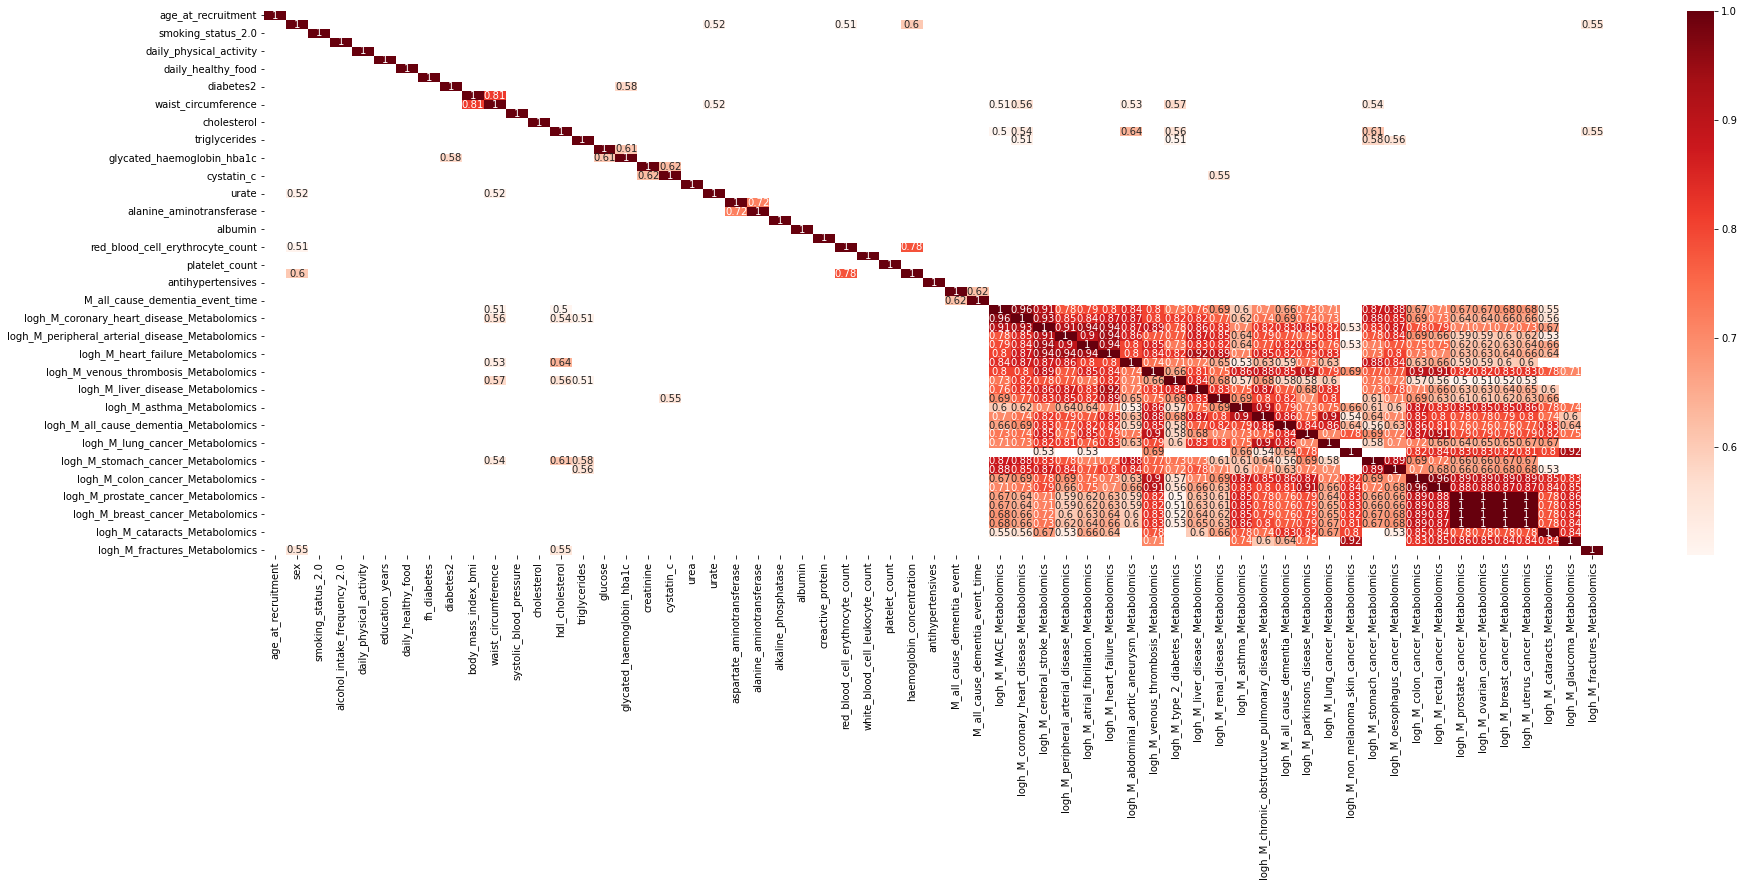

In [137]:
filteredDf = dfCorr[((dfCorr >= .5) | (dfCorr <= -.5))]
plt.figure(figsize=(30,10))
sn.heatmap(filteredDf, annot=True, cmap="Reds")
plt.show()

In [ ]:
cph = fit_cox(train_partition[covariates + [f"{endpoint}_event", f"{endpoint}_event_time"]], endpoint)
                pickle.dump(cph, open(cph_path, "wb"))

In [ ]:
for s in [metabolomics]:
    print(s)
    cph = fit_cox2(data_all.query("partition==1&split=='train'")[s + [f"{endpoint}_event", f"{endpoint}_event_time"]], endpoint)
    cph.print_summary()

## Apply COX to data

In [59]:
import joblib
@ray.remote
def get_cph(path): 
    with open(path,'rb') as f:
        cph = pickle.load(f)
    return cph#return pd.read_csv(f"{path[:-8]}.csv", index_col=0)

In [211]:
ray.shutdown()

In [60]:
import glob, os
cph_dict = {}
for path in tqdm(glob.glob(f"{dump_path}/*.p")):
    cph_dict[pathlib.Path(path).stem] = get_cph.remote(path)

  0%|          | 0/8976 [00:00<?, ?it/s]

In [61]:
for path in tqdm(glob.glob(f"{dump_path}/*.p")):
    cph_dict[pathlib.Path(path).stem] = ray.get(cph_dict[pathlib.Path(path).stem])

  0%|          | 0/8976 [00:00<?, ?it/s]

In [62]:
def predict_cox(endpoints, modules, partitions, data_test, cph_dict):
    times = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
    time_cols = {t: f"Ft_{t}" for t in times}
    
    results = []
    test_preds = []
    for module in tqdm(modules):
        for endpoint in tqdm(endpoints):
            features = get_features(metabolomics, endpoint)
            eids_incl = eids_dict[endpoint] 
            test_endpoint = data_test.query("eid==@eids_incl")
            for partition in partitions:
                test_partition = test_endpoint.query("partition==@partition")
                for feature_set, covariates in features[module].items():
                    #print(endpoint, feature_set)
                    if endpoint == "M_type_2_diabetes":
                        if "diabetes1" in covariates: covariates = [c for c in covariates if c!="diabetes1"]
                        if "diabetes2" in covariates: covariates = [c for c in covariates if c!="diabetes2"]
                    if endpoint in ["M_prostate_cancer", "M_ovarian_cancer", "M_breast_cancer", "M_uterus_cancer"]:
                        if "sex" in covariates: covariates = [c for c in covariates if c!="sex"]
                    cph = cph_dict[f"{module}_{endpoint}_{feature_set}_{partition}"]
                    surv_test = 1-cph.predict_survival_function(test_partition[covariates+ [f"{endpoint}_event", f"{endpoint}_event_time"]], times=times) 
                    temp_pred = test_partition.reset_index()[["eid"]].assign(endpoint=endpoint, module=module, features=feature_set, partition=partition)
                    for t, col in time_cols.items(): temp_pred[col] = surv_test.T[t].to_list()
                    test_preds.append(temp_pred)
                    results.append({"endpoint": endpoint,
                                    "module": module,
                                    "features": feature_set,
                                    "HR_dict": cph.hazard_ratios_.to_dict(),
                                    "partition": partition,
                                    "cph": cph,
                                   })
    return results, test_preds

In [63]:
results, test_preds = predict_cox(endpoints, modules, partitions, data_test, cph_dict)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

## Save Predictions

In [64]:
predictions = pd.concat(test_preds, axis=0).reset_index()

In [65]:
predictions.to_feather(f"{data_results_path}/predictions_{run}_metabolomics.feather")

In [66]:
f"{data_results_path}/predictions_{run}_metabolomics.feather"

'/sc-projects/sc-proj-ukb-cvd/results/projects/21_metabolomics_multitask/data/predictions_211007_metabolomics.feather'

In [67]:
predictions.value_counts(["module", "features"])

module  features            
COX     ASCVD                   2604192
DS      Age+Sex+Metabolomics    2604192
        SCORE2+Metabolomics     2604192
        SCORE+Metabolomics      2604192
        QRISK3+Metabolomics     2604192
        PANEL+Metabolomics      2604192
        Metabolomics            2604192
        FRS+Metabolomics        2604192
        ASCVD+Metabolomics      2604192
COX     Age+Sex                 2604192
        SCORE2                  2604192
        SCORE                   2604192
        QRISK3                  2604192
        PANEL                   2604192
        Metabolomics            2604192
        FRS                     2604192
PCA     Metabolomics            2604192
dtype: int64

In [68]:
predictions.value_counts(["endpoint"])

endpoint                               
M_lung_cancer                              2004232
M_abdominal_aortic_aneurysm                2003042
M_parkinsons_disease                       2001988
M_rectal_cancer                            2000883
M_colon_cancer                             1999489
M_cerebral_stroke                          1994814
M_all_cause_dementia                       1993165
M_atrial_fibrillation                      1972442
M_non_melanoma_skin_cancer                 1971932
M_glaucoma                                 1970878
M_liver_disease                            1962956
M_peripheral_arterial_disease              1957244
M_venous_thrombosis                        1954762
M_cataracts                                1943865
M_heart_failure                            1931812
M_type_2_diabetes                          1899665
M_renal_disease                            1898968
M_chronic_obstructuve_pulmonary_disease    1877905
M_coronary_heart_disease                  

## Save COX models

In [69]:
results_df = pd.DataFrame().append(results, ignore_index=True)

In [70]:
results_df

,endpoint,module,features,HR_dict,partition,cph
0,M_MACE,PCA,Metabolomics,"{'NMR_PCA0': 1.0245273671289346, 'NMR_PCA1': 0...",0,<lifelines.CoxPHFitter: fitted with 76127 tota...
1,M_MACE,PCA,Metabolomics,"{'NMR_PCA0': 1.0248745153282046, 'NMR_PCA1': 0...",1,<lifelines.CoxPHFitter: fitted with 76087 tota...
2,M_MACE,PCA,Metabolomics,"{'NMR_PCA0': 1.025513325485147, 'NMR_PCA1': 0....",2,<lifelines.CoxPHFitter: fitted with 77184 tota...
3,M_MACE,PCA,Metabolomics,"{'NMR_PCA0': 1.0250265302599963, 'NMR_PCA1': 0...",3,<lifelines.CoxPHFitter: fitted with 77807 tota...
4,M_MACE,PCA,Metabolomics,"{'NMR_PCA0': 1.0254650082895593, 'NMR_PCA1': 0...",4,<lifelines.CoxPHFitter: fitted with 77842 tota...
...,...,...,...,...,...,...
8971,M_fractures,DS,FRS+Metabolomics,"{'age_at_recruitment': 1.2438127255112104, 'se...",21,<lifelines.CoxPHFitter: fitted with 95702 tota...
8972,M_fractures,DS,SCORE+Metabolomics,"{'age_at_recruitment': 1.246888545818227, 'sex...",21,<lifelines.CoxPHFitter: fitted with 95702 tota...
8973,M_fractures,DS,SCORE2+Metabolomics,"{'age_at_recruitment': 1.2457452956071307, 'se...",21,<lifelines.CoxPHFitter: fitted with 95702 tota...
8974,M_fractures,DS,ASCVD+Metabolomics,"{'age_at_recruitment': 1.2324725089486581, 'se...",21,<lifelines.CoxPHFitter: fitted with 95702 tota...


In [71]:
def get_hr(hr_dict, endpoint): 
    if f"logh_{endpoint}_Metabolomics" in hr_dict: 
        hr = hr_dict[f"logh_{endpoint}_Metabolomics"]
    else:
        hr = np.nan
    return hr

In [72]:
import pickle
results_df["HR_metabolomics"] = [get_hr(hr_dict, endpoint) for endpoint, hr_dict in zip(results_df["endpoint"], results_df["HR_dict"])]
results_df.drop(columns=["cph"]).to_feather(f"{data_results_path}/cox_{run}_metabolomics.feather")

In [73]:
results_df

,endpoint,module,features,HR_dict,partition,cph,HR_metabolomics
0,M_MACE,PCA,Metabolomics,"{'NMR_PCA0': 1.0245273671289346, 'NMR_PCA1': 0...",0,<lifelines.CoxPHFitter: fitted with 76127 tota...,NaN
1,M_MACE,PCA,Metabolomics,"{'NMR_PCA0': 1.0248745153282046, 'NMR_PCA1': 0...",1,<lifelines.CoxPHFitter: fitted with 76087 tota...,NaN
2,M_MACE,PCA,Metabolomics,"{'NMR_PCA0': 1.025513325485147, 'NMR_PCA1': 0....",2,<lifelines.CoxPHFitter: fitted with 77184 tota...,NaN
3,M_MACE,PCA,Metabolomics,"{'NMR_PCA0': 1.0250265302599963, 'NMR_PCA1': 0...",3,<lifelines.CoxPHFitter: fitted with 77807 tota...,NaN
4,M_MACE,PCA,Metabolomics,"{'NMR_PCA0': 1.0254650082895593, 'NMR_PCA1': 0...",4,<lifelines.CoxPHFitter: fitted with 77842 tota...,NaN
...,...,...,...,...,...,...,...
8971,M_fractures,DS,FRS+Metabolomics,"{'age_at_recruitment': 1.2438127255112104, 'se...",21,<lifelines.CoxPHFitter: fitted with 95702 tota...,1.301195
8972,M_fractures,DS,SCORE+Metabolomics,"{'age_at_recruitment': 1.246888545818227, 'sex...",21,<lifelines.CoxPHFitter: fitted with 95702 tota...,1.299793
8973,M_fractures,DS,SCORE2+Metabolomics,"{'age_at_recruitment': 1.2457452956071307, 'se...",21,<lifelines.CoxPHFitter: fitted with 95702 tota...,1.292078
8974,M_fractures,DS,ASCVD+Metabolomics,"{'age_at_recruitment': 1.2324725089486581, 'se...",21,<lifelines.CoxPHFitter: fitted with 95702 tota...,1.284617


In [74]:
#!ls -lah $data_results_path
!ls -lah $dump_path | tail

-rwxrwx---  1 steinfej posix-nogroup 6.9M Oct  6 15:04 PCA_M_venous_thrombosis_Metabolomics_2.p
-rwxrwx---  1 steinfej posix-nogroup 7.4M Oct  6 15:04 PCA_M_venous_thrombosis_Metabolomics_20.p
-rwxrwx---  1 steinfej posix-nogroup 7.4M Oct  6 15:04 PCA_M_venous_thrombosis_Metabolomics_21.p
-rwxrwx---  1 steinfej posix-nogroup 6.9M Oct  6 15:04 PCA_M_venous_thrombosis_Metabolomics_3.p
-rwxrwx---  1 steinfej posix-nogroup 6.9M Oct  6 15:04 PCA_M_venous_thrombosis_Metabolomics_4.p
-rwxrwx---  1 steinfej posix-nogroup 7.0M Oct  6 15:04 PCA_M_venous_thrombosis_Metabolomics_5.p
-rwxrwx---  1 steinfej posix-nogroup 7.0M Oct  6 15:04 PCA_M_venous_thrombosis_Metabolomics_6.p
-rwxrwx---  1 steinfej posix-nogroup 7.0M Oct  6 15:04 PCA_M_venous_thrombosis_Metabolomics_7.p
-rwxrwx---  1 steinfej posix-nogroup 7.0M Oct  6 15:04 PCA_M_venous_thrombosis_Metabolomics_8.p
-rwxrwx---  1 steinfej posix-nogroup 7.0M Oct  6 15:04 PCA_M_venous_thrombosis_Metabolomics_9.p


In [13]:
# STORE HRs in different table


In [87]:
import glob
import pickle
import re

In [88]:
def _extract_logh(d):
    for k, v in d.items():
        if k.startswith('logh_'):
            return v

In [90]:
res

('M_heart_failure', 'Age+Sex+Metabolomics', '6')

In [91]:
# load models and put HRs into a df:
df_dict = {"endpoint": [],
           "partition": [],
           "features": [],
           "HR_Metabolomics": []
          }

for fp in glob.glob(os.path.join(dump_path,"DS_*.p")):
    try:
        res = re.search("(M_[a-zA-Z_]+[2a-zA-Z_]+)_([3a-zA-Z+]+)_(\d+)", fp).groups()

        df_dict['endpoint'].append(res[0])
        df_dict['features'].append(res[1])
        df_dict['partition'].append(res[2])

        cph = pickle.load(open(fp, "rb"))
        HR = _extract_logh(cph.hazard_ratios_.to_dict())
    #     HR = cph.hazard_ratios_.to_dict()[f'logh_{res[0]}_Metabolomics']
        df_dict['HR_Metabolomics'].append(HR)
    except:
        print(fp)

In [93]:
HR_df = pd.DataFrame.from_dict(df_dict, orient="columns")
HR_df['module'] = 'DS'

In [94]:
HR_df.head()

,endpoint,partition,features,HR_Metabolomics,module
0,M_peripheral_arterial_disease,7,ASCVD+Metabolomics,1.956868,DS
1,M_liver_disease,17,Metabolomics,3.007731,DS
2,M_MACE,8,AgeSexMetabolomics,2.621761,DS
3,M_venous_thrombosis,20,ASCVD+Metabolomics,2.725824,DS
4,M_liver_disease,2,ASCVD+Metabolomics,2.659992,DS


In [75]:
HR_df.to_feather(f"{data_results_path}/MET_HRs_210819_metabolomics.feather")

In [44]:
results_df = results_df.assign(HR_logh=results_df['hazard_ratio'].apply(_extract_logh))

In [45]:
results_df['features'].unique()

array(['Age+Sex', 'Metabolomics', 'Age+Sex+Metabolomics',
       'AgeSexMetabolomics'], dtype=object)

In [37]:
results_df[["endpoint", "module", "features", 'HR_logh']].reset_index().to_feather(f"{data_results_path}/MET_HRs_{run}_metabolomics.feather")

In [39]:
f"{data_results_path}/MET_HRs_{run}_metabolomics.feather"

'/data/analysis/ag-reils/ag-reils-shared/cardioRS/results/projects/21_metabolomics_multitask/data/MET_HRs_210821_metabolomics.feather'

In [ ]:
raise NotImplementedError()

In [38]:
# Other stuff

In [ ]:
cph = results_df.set_index(["endpoint", "module", "features"]).loc[('M_MACE', "DS", "Age+Sex+Metabolomics"), "cph"].iloc[0]

In [ ]:
cph.print_summary()

In [ ]:
dir(cph)

In [ ]:
cph.summary["coef"]

In [ ]:
cph.baseline_cumulative_hazard_

In [ ]:
cph.baseline_hazard_

In [ ]:
dir(cph)

In [ ]:
cph.print_summary()

In [ ]:
import plotly.express as px
scores_plot = ["COX_AgeSex", "DeepSurv_AgeSexMetabolomics"]
temp = results_df.assign(score = lambda x: x.module + "_" + x.features).query("score==@scores_plot")
fig = px.scatter(temp, y="cindex", x="score", color="features", facet_col="endpoint", facet_col_wrap=12, template="plotly_dark",
               category_orders={"features": ["COX_Metabolomics", "DeepSurv_Metabolomics", 
                                             "COX_AgeSex", 
                                             "COX_AgeSexMetabolomics", "DeepSurv_AgeSexMetabolomics"]})
fig.update_xaxes(matches=None)
#fig.update_yaxes(matches=None)
fig.show("png", width=1500, height=1000)

In [ ]:
import plotly.express as px
temp = results_df.assign(score = lambda x: x.module + "_" + x.features)
fig = px.scatter(temp, y="cindex", x="score", color="features", facet_col="endpoint", facet_col_wrap=5, template="plotly_dark",
               category_orders={"features": ["COX_Metabolomics", "DeepSurv_Metabolomics", 
                                             "COX_AgeSex", 
                                             "COX_AgeSexMetabolomics", "DeepSurv_AgeSexMetabolomics"]})
fig.update_xaxes(matches=None)
#fig.update_yaxes(matches=None)
fig.show("png", width=1500, height=1000)

In [ ]:
import plotly.express as px
temp = results_df.assign(score = lambda x: x.module + "_" + x.features)
fig = px.scatter(temp, y="cindex", x="score", color="features", facet_col="endpoint", facet_col_wrap=5, template="plotly_dark",
               category_orders={"features": ["COX_Metabolomics", "DeepSurv_Metabolomics", 
                                             "COX_AgeSex", "DeepSurv_AgeSex",
                                             "COX_AgeSexMetabolomics", "DeepSurv_AgeSexMetabolomics"]})
fig.update_xaxes(matches=None)
#fig.update_yaxes(matches=None)
fig.show("png", width=1500, height=1000)

In [ ]:
dpath = "/data/analysis/ag-reils/steinfej/data/3_datasets_post/210730_imaging_visit"
for partition in range(5):
    for split in ["train", "valid", "test"]:
        ddf = pd.read_feather(f"{dpath}/partition_{partition}/{split}/data.feather")
        print(partition, split, len(ddf))

In [ ]:
data_X = pd.read_feather("/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/3_datasets_post/210730_imaging_visit/data_merged.feather")

In [ ]:
data_X.set_index("uk_biobank_assessment_centre_2_0").index.value_counts().index.to_list()

In [ ]:
data_X.set_index("uk_biobank_assessment_centre_2_0").index.value_counts()

In [ ]:
import plotly.express as px
temp = results_df.assign(score = lambda x: x.module + "_" + x.features)
fig = px.scatter(temp, y="cindex", x="score", color="features", facet_col="endpoint", facet_col_wrap=5, template="plotly_dark",
               category_orders={"features": ["COX_Metabolomics", "DeepSurv_Metabolomics", 
                                             "COX_AgeSex", "DeepSurv_AgeSex",
                                             "COX_AgeSexMetabolomics", "DeepSurv_AgeSexMetabolomics"]})
fig.update_xaxes(matches=None)
#fig.update_yaxes(matches=None)
fig.show("png", width=1500, height=1000)

In [ ]:
import plotly.express as px
temp = results_df.assign(score = lambda x: x.module + "_" + x.features)
fig = px.scatter(temp, y="cindex", x="score", color="features", facet_col="endpoint", facet_col_wrap=5, template="plotly_dark",
               category_orders={"features": ["COX_Metabolomics", "DeepSurv_Metabolomics", 
                                             "COX_AgeSex", "DeepSurv_AgeSex",
                                             "COX_AgeSexMetabolomics", "DeepSurv_AgeSexMetabolomics"]})
fig.update_xaxes(matches=None)
#fig.update_yaxes(matches=None)
fig.show("png", width=1500, height=1000)

In [ ]:
import plotly.express as px
temp = results_df.assign(score = lambda x: x.module + "_" + x.features)
fig = px.scatter(temp, y="cindex", x="score", color="features", facet_col="endpoint", facet_col_wrap=5, template="plotly_dark",
               category_orders={"features": ["COX_Metabolomics", "DeepSurv_Metabolomics", 
                                             "COX_AgeSex", "DeepSurv_AgeSex",
                                             "COX_AgeSexMetabolomics", "DeepSurv_AgeSexMetabolomics"]})
fig.update_xaxes(matches=None)
fig.update_yaxes(matches=None)
fig.show("png", width=1500, height=1000)

In [ ]:
import plotly.express as px
temp = results_df.assign(score = lambda x: x.module + "_" + x.features)
fig = px.scatter(temp, y="cindex", x="score", color="features", facet_col="endpoint", facet_col_wrap=5, template="plotly_dark",
               category_orders={"features": ["COX_Metabolomics", "DeepSurv_Metabolomics", 
                                             "COX_AgeSex", "DeepSurv_AgeSex",
                                             "COX_AgeSexMetabolomics", "DeepSurv_AgeSexMetabolomics"]})
fig.update_xaxes(matches=None)
fig.update_yaxes(matches=None)
fig.show("png", width=1500, height=1000)

In [ ]:
import plotly.express as px
temp = results_df.assign(score = lambda x: x.module + "_" + x.features)
fig = px.scatter(temp, y="cindex", x="score", color="features", facet_col="endpoint", facet_col_wrap=5, template="plotly_dark",
               category_orders={"features": ["COX_Metabolomics", "DeepSurv_Metabolomics", 
                                             "COX_AgeSex", "DeepSurv_AgeSex",
                                             "COX_AgeSexMetabolomics", "DeepSurv_AgeSexMetabolomics"]})
fig.update_xaxes(matches=None)
fig.update_yaxes(matches=None)
fig.show("png", width=1500, height=1000)

In [ ]:
import plotly.express as px
temp = results_df.assign(score = lambda x: x.module + "_" + x.features)
fig = px.scatter(temp, y="cindex", x="score", color="features", facet_col="endpoint", facet_col_wrap=5, template="plotly_dark",
               category_orders={"features": ["COX_Metabolomics", "DeepSurv_Metabolomics", 
                                             "COX_AgeSex", "DeepSurv_AgeSex",
                                             "COX_AgeSexMetabolomics", "DeepSurv_AgeSexMetabolomics"]})
fig.update_xaxes(matches=None)
fig.update_yaxes(matches=None)
fig.show("png", width=1500, height=1000)

In [ ]:
import plotly.express as px
temp = results_df.assign(score = lambda x: x.module + "_" + x.features)
fig = px.scatter(temp, y="cindex", x="score", color="features", facet_col="endpoint", facet_col_wrap=5, template="plotly_dark",
               category_orders={"features": ["COX_Metabolomics", "DeepSurv_Metabolomics", 
                                             "COX_AgeSex", "DeepSurv_AgeSex",
                                             "COX_AgeSexMetabolomics", "DeepSurv_AgeSexMetabolomics"]})
fig.update_xaxes(matches=None)
#fig.update_yaxes(matches=None)
fig.show("png", width=1500, height=1000)

In [ ]:
import plotly.express as px
temp = results_df.assign(score = lambda x: x.module + "_" + x.features)
fig = px.violin(temp, y="cindex", x="features", color="features", box=True, points="all", facet_col="endpoint", facet_col_wrap=4,
               category_orders={"features": ["Metabolomics", "AgeSex", "AgeSexMetabolomics"]})
fig.update_xaxes(matches=None)
fig.show("png", width=1500, height=1000)

In [ ]:
preds.to_feather(f"{data_results_path}/predictions_model_210720.feather")

In [ ]:
from lifelines import RegressionFitter

In [ ]:
self._central_values = self._compute_central_values_of_raw_training_data(df, self.strata)
self.baseline_survival_ = self._compute_baseline_survival()
baseline_hazard_ = self._compute_baseline_hazards(predicted_partial_hazards_)
baseline_cumulative_hazard_ = self._compute_baseline_cumulative_hazard(baseline_hazard_)

In [ ]:
cph_semi = CoxPHFitter().fit(rossi, 'week', event_col='arrest')
cph_piecewise = CoxPHFitter(baseline_estimation_method="piecewise", breakpoints=[20, 35]).fit(rossi, 'week', event_col='arrest')

ax = cph_spline.baseline_cumulative_hazard_.plot()